In [1]:
import gc
gc.collect()

34

In [2]:
import sys
# IN_COLAB = "google.colab" in sys.modules
# if IN_COLAB:
#     !pip3 install scanpy
#     from google.colab import drive
#     drive.mount('/content/drive')
#     import sys
#     sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import torch

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Arial'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi':300})

import warnings
warnings.filterwarnings('ignore')

## Load Starfysh

# from starfysh import (AA, utils, plot_utils, post_analysis, utils_integrate)
# from starfysh import starfysh as sf_model

In [5]:
# sys.path.append('../')
# sys.path.append('/Users/siyuhe/opt/miniconda3/lib/python3.9/site-packages')
# from starfysh import (AA, utils, plot_utils, post_analysis)
# from starfysh import starfysh as sf_model
# #sys.path.append('../simulation/')
# #import utils as benchmark_utils

In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import json
import matplotlib.pyplot as plt

min_genes_values = {
    'SLV11': 150,
    'SLV12': 50,
    'SLV13': 50,
    'SLV14': 50,
    'SLV15': 50,
    'SLV16': 150,
    'SLV17': 50,
    'SLV18': 150,# Change as needed for each sample
}



def load_visium_data(base_path, sample_id, min_genes=50, n_top_genes=2000, mt_thld=20):
    """
    Load and process Visium spatial data
    
    Parameters:
    -----------
    base_path : str
        Path to the base directory containing data
    sample_id : str
        ID of the sample to process
    min_genes : int, optional
        Minimum number of genes for filtering (default: 50)
    n_top_genes : int, optional
        Number of top variable genes to select (default: 2000)
    mt_thld : int, optional
        Threshold for mitochondrial gene percentage (default: 20)
    
    Returns:
    --------
    tuple
        (adata, adata_norm, img_metadata)
    """
    # Read tissue positions
    tissue_positions = pd.read_parquet(os.path.join(
        base_path,
        sample_id,
        'binned_outputs',
        'square_016um',
        'spatial',
        'tissue_positions.parquet'
    ))

    # Read gene expression data
    adata = sc.read_10x_h5(os.path.join(
        base_path,
        sample_id,
        'binned_outputs',
        'square_016um',
        'filtered_feature_bc_matrix.h5'
    ))

    # Match positions with expression data
    matched_positions = tissue_positions[tissue_positions['barcode'].isin(adata.obs.index)]
    matched_positions = matched_positions.set_index('barcode')
    matched_positions = matched_positions.loc[adata.obs.index]

    # Add spatial coordinates to adata
    adata.obs[['in_tissue','array_row','array_col','pxl_row_in_fullres', 'pxl_col_in_fullres']] = matched_positions[
        ['in_tissue','array_row','array_col','pxl_row_in_fullres', 'pxl_col_in_fullres']]

    # Make var names unique and add sample ID
    adata.var_names_make_unique()
    adata.obs['sample'] = sample_id

    # Clean up var names if needed
    if '_index' in adata.var.columns:
        adata.var_names = adata.var['_index']
        adata.var_names.name = 'Genes'
        adata.var.drop('_index', axis=1, inplace=True)

    # Calculate QC metrics
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # Basic filtering
    sc.pp.filter_cells(adata, min_counts=min_genes)
    #sc.pp.filter_genes(adata, min_cells=100)
    

    # Create copy for normalized version
    adata_raw = adata.copy()

    # Additional filtering and normalization
    adata.var['mt'] = np.logical_or(
        adata.var_names.str.startswith('MT-'),
        adata.var_names.str.startswith('mt-'))
    adata.var['rb'] = (
        adata.var_names.str.startswith('RP-') |
        adata.var_names.str.startswith('rp-'))

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
    mask_cell = adata.obs['pct_counts_mt'] < mt_thld
    mask_gene = np.logical_and(~adata.var['mt'], ~adata.var['rb'])

    adata = adata[mask_cell, mask_gene]

    # Normalize and log transform
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)

    # Find variable genes
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=n_top_genes, inplace=True)

    # Filter raw data to match normalized data
    adata_raw = adata_raw[adata.obs_names, adata.var_names]
    adata_raw.var['highly_variable'] = adata.var['highly_variable']
    adata_raw.obs = adata.obs

    # Prepare image metadata
    # Load scale factors
    with open(os.path.join(base_path, sample_id, 'binned_outputs/square_016um/spatial/scalefactors_json.json'), 'r') as f:
        scalefactor = json.load(f)

    # Load high-res image
    img = plt.imread(os.path.join(base_path, sample_id, 'spatial/tissue_hires_image.png'))

    # Prepare map info
    map_info = matched_positions[['in_tissue','array_row','array_col','pxl_row_in_fullres', 'pxl_col_in_fullres']]
    map_info['imagerow'] = pd.to_numeric(map_info['pxl_row_in_fullres'], errors='coerce').fillna(0).astype(int)
    map_info['imagecol'] = pd.to_numeric(map_info['pxl_col_in_fullres'], errors='coerce').fillna(0).astype(int)
    map_info = map_info[['array_row','array_col','imagerow','imagecol']]

    img_metadata = {
        'img': img,
        'map_info': map_info,
        'scalefactor': scalefactor
    }

    return adata_raw, adata, img_metadata

In [4]:
meta_info = [
    ['SLV11', 'C159', 'Antrum', 'Severe'],
    ['SLV12', 'C162', 'Rectum', 'Mild'],
    ['SLV13', 'C98', 'Stomach_Body', 'Severe'],
    ['SLV14', 'C159', 'Rectum', 'Severe'],
    ['SLV15', 'C179', 'Antrum', 'Mild'],
    ['SLV16', 'C179', 'Ascending_Colon', 'Mild'],
    ['SLV17', 'ND001', 'Ascending_Colon', 'ND'],
    ['SLV18', 'C162', 'Stomach', 'Mild']
]
meta_info = pd.DataFrame(meta_info,columns=['sample','patient','tissue_type','grade'])
# base_path = '/Users/lingting/Documents/GVHD_project/visiumHD/data/'
# sig_file_name = '/Users/lingting/Documents/GVHD_project/Spatial data/data/GVHD_spatial_signature_v8_major_curated_unique_epi_tcells_subset.csv'

# # Load data
# adata_all = []
# adata_normed_all = []
# img_metadata_all = {}

# for sample_id in meta_info['sample']:
#     print(sample_id)
#     adata, adata_normed, img_metadata = load_visium_data(base_path, sample_id, min_genes=min_genes_values.get(sample_id, 50), n_top_genes=2000, mt_thld=20 )  # root data directory


#     adata_normed = adata_normed[adata_normed.obs.index.isin(adata.obs.index)]
#     adata_all.append(adata)
    
    
    
#     adata.obs['patient']=meta_info['patient'][list(meta_info['sample']).index(sample_id)]
#     adata.obs['sample_type']=meta_info['tissue_type'][list(meta_info['sample']).index(sample_id)]
#     adata.obs['grade']=meta_info['grade'][list(meta_info['sample']).index(sample_id)]
#     adata.obs_names  = adata.obs_names+'-'+sample_id

#     adata_normed.obs_names  = adata_normed.obs_names+'-'+sample_id

#     adata_normed.obs['patient']=adata.obs['patient']
#     adata_normed.obs['sample_type']=adata.obs['sample_type']
#     adata_normed.obs['grade']=adata.obs['grade']
#     adata_normed_all.append(adata_normed)

#     img_metadata['map_info'].index = img_metadata['map_info'].index+'-'+sample_id
#     map_info = img_metadata['map_info']
#     map_info = map_info[map_info.index.isin(adata.obs.index)]
#     img_metadata['map_info'] = map_info
    
#     img_metadata_all[sample_id] = img_metadata 
    

# # Save concat data
# adata_all = anndata.concat(adata_all)
# adata_normed_all = anndata.concat(adata_normed_all)

# sc.pp.highly_variable_genes(adata_normed_all)
# adata_all.uns = adata_normed_all.uns
# adata_all.var = adata_normed_all.var

# adata_all.write(os.path.join(base_path, 'adata_integrate.h5ad'))
# adata_normed_all.write(os.path.join(base_path, 'adata_normed_integrate.h5ad'))

## fig 4k

In [5]:
#adata_integrate = sc.read_h5ad('adata_fig4_0904_23.h5ad')
base_path = '/home/jz3553/data/'
adata_integrate = anndata.read(os.path.join(base_path, 'adata_integrate_final.h5ad'))

In [6]:
adata_integrate

AnnData object with n_obs × n_vars = 232882 × 1133
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'patient', 'sample_type', 'grade', 'leiden', 'pheno_louvain', 'hub', 'Plasma cells', 'Myeloid', 'Fibroblast', 'B cells', 'NK cells', 'Instestinal_Epithelial cells', 'Enterocyte', 'Stomach_epithelial_cells', 'Stomach_stem_cells', 'Endothelial cell', 'Mast cell', 'CD8+ Effector T  cells', 'CD4+ Effector T cells', 'CD4+ Central Memory T cells', 'CD8+ Cytotoxic Unconventional T cells', 'CD8+ Proliferating T cells', 'CD4+ Regulatory T cells', 'CD8+ Homeostatic Unconventional T cells', 'CD8+ Tissue Resident Memory T cells', 'CD8+ Transitioning  Resident T cells', '

In [12]:
hub_stem_list = [4,5,8,30,32]

##### Starfysh sample integration

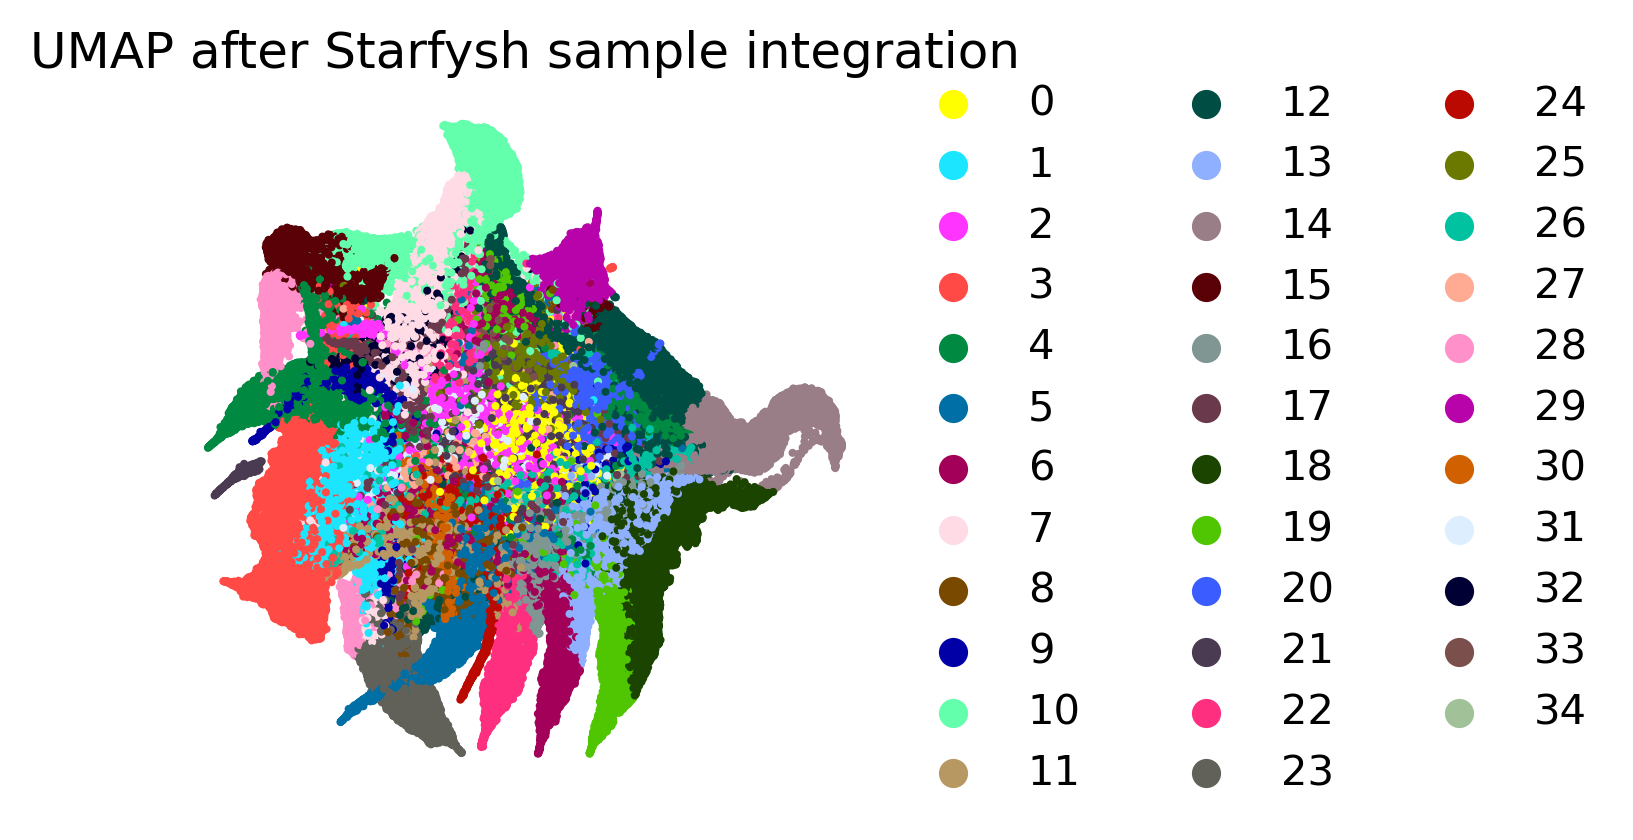

In [7]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]  # DejaVu Sans is widely available
sc.pl.umap(adata_integrate, color="hub", frameon=False, s=15, title="UMAP after Starfysh sample integration")
plt.show()

In [8]:
hub_stem_percent  =[]
for i in adata_integrate.obs['hub'].unique():
    adata_integrate_temp = adata_integrate[adata_integrate.obs['hub']==i]
    hub_stem_percent.append([i,adata_integrate_temp.obs[['Intestine_Epithelial Stem cell','Stomach_stem_cells']].sum(axis=1).mean()])
hub_stem_percent = pd.DataFrame(hub_stem_percent).sort_values(by =1,ascending=False)

In [9]:
# # Creating line plot
# plt.figure(figsize=(12,2.5),dpi=900)
# plt.plot(list(range(hub_stem_percent.shape[0])), hub_stem_percent.iloc[:,1]*100, marker='o')

# # Adding labels and title
# plt.xlabel('Hubs')
# plt.ylabel('Average stem cell percentages (%)')

# # Customizing x-ticks
# plt.xticks(ticks=list(range(hub_stem_percent.shape[0])), labels=hub_stem_percent.iloc[:,0])

# # Showing plot
# plt.grid(True)
# plt.show()

In [9]:
# First, let's get the order right
hub_order = hub_stem_percent.iloc[:,0].tolist()  # Get current hub order
hub_colors_ordered = [adata_integrate.uns['hub_colors'][hub] for hub in hub_order]  # Reorder colors to match

# # Creating bar plot with ordered colors
# plt.figure(figsize=(12,3), dpi=300)
# plt.bar(range(hub_stem_percent.shape[0]), 
#         hub_stem_percent.iloc[:,1]*100,
#         color=hub_colors_ordered)  # Using reordered colors

# # Add horizontal line at 33%
# plt.axhline(y=33, color='black', linestyle='--', alpha=0.7)

# # Adding labels and title
# plt.xlabel('Hubs')
# plt.ylabel('Stem Cell \nPercentages (%)')

# # Customizing x-ticks
# plt.xticks(ticks=list(range(hub_stem_percent.shape[0])), 
#           labels=hub_stem_percent.iloc[:,0],
#           rotation=45)

# # Adding grid for y-axis only
# plt.grid(False, axis='y')
# plt.tight_layout()
# for ext in ['pdf', 'png', 'svg']:
#     plt.savefig(
#         f'/home/jz3553/figures/stem_percentage_hub_bar_plot.{ext}',
#         bbox_inches='tight', 
#         dpi=300)
# plt.show()

In [13]:
adata_integrate.obs['stem'] = adata_integrate.obs['hub'].isin(hub_stem_list).astype(str)
# output_folder = '/home/jz3553/figures'
# for sample in meta_info['sample']:
#         # Path to the JSON file
#     file_path = f'/Users/lingting/Documents/GVHD_project/visiumHD/data/{sample}/binned_outputs/square_016um/spatial/scalefactors_json.json'
    
#     # Open and load the JSON file
#     with open(file_path, 'r') as file:
#         scalefactor = json.load(file)
    
#     # Run the function
#     plot_categories_on_histology(
#         adata=adata_integrate[adata_integrate.obs['sample']==sample],
#         column='stem',  # Column in adata.obs containing the categories
#         his_loc= f'/Users/lingting/Documents/GVHD_project/visiumHD/data/{sample}/spatial/tissue_hires_image.png',  # Path to the histology image
#         scalefactors=scalefactor,
#         size=0.6,
#         output_folder=output_folder,  # Replace with your output directory
#         sample_id=sample, 
#         color_map = new_colormap
#     )

In [14]:
def plot_dual_violin(data1, data2, y1_label, y2_label,y_label, title=None, sample_id=None, figsize=(10,6)):
    """
    Create a split violin plot for comparing two distributions with custom colors
    
    Args:
        data1: Array-like, data for CD8 effector cells (blue)
        data2: Array-like, data for CD4 effector cells (orange)
        y1_label: String, label for first group
        y2_label: String, label for second group
        title: String, optional plot title
        sample_id: String, sample identifier
        figsize: Tuple, figure dimensions
    Returns:
        tuple: (figure, (ax1, ax2)) where ax1 and ax2 are the same axis object
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create DataFrame in the format needed for seaborn
    import pandas as pd
    import numpy as np
    
    df = pd.DataFrame({
        'value': np.concatenate([data1, data2]),
        'group': np.concatenate([
            np.full(len(data1), sample_id),
            np.full(len(data2), sample_id)
        ]),
        'category': np.concatenate([
            np.full(len(data1), y1_label),
            np.full(len(data2), y2_label)
        ])
    })
    
    # Create custom color palette
    custom_palette = {y1_label: '#1f77b4', y2_label: '#ff7f0e'}
    
    # Create the split violin plot
    sns.violinplot(
        data=df,
        x='group',
        y='value',
        hue='category',
        split=True,
        inner='quart',
        fill=False,
        ax=ax,
        palette=custom_palette
    )
    
    # Calculate statistics
    stat, pvalue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    n1 = len(data1)
    n2 = len(data2)
    total_samples = n1 + n2
    bonferroni_pvalue = pvalue * total_samples
    pvalue_corrrected = min(bonferroni_pvalue, 1.0)
    
    # Add title with p-value if specified
    if title:
        plt.title(f'{title}\np-value = {pvalue:.2e}')
    
    # Clean up the plot
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Adjust layout
    plt.tight_layout()
    
    # Return fig and tuple of (ax, ax) to match expected unpacking
    return fig, (ax, ax)

In [15]:
from scipy import stats
stem_adata = adata_integrate[adata_integrate.obs['hub'].isin(hub_stem_list)]
non_stem_adata = adata_integrate[~adata_integrate.obs['hub'].isin(hub_stem_list)]
# # Create plots comparing intact vs combined loss regions
# for cell_type in adata_integrate.obs.columns[adata_integrate.obs.columns.get_loc('Plasma cells'):
#                                           adata_integrate.obs.columns.get_loc('Stomach_Body_Epithelial_cells')+1]:
#     fig, (ax1, ax2) = plot_dual_violin(
#         np.log(stem_adata.obs[cell_type]), 
#         np.log(non_stem_adata.obs[cell_type]),  # Using combined loss data
#         y1_label='Stem hubs',
#         y2_label='Non-stem hubs',
#         sample_id=sample_id,
#         title=f"{cell_type}",
#         y_label='Proportion',
#         figsize=(2,2)
#     )

#     # Save figures
#     for ext in ['pdf', 'png', 'svg']:
#         fig.savefig(
#             f'/home/jz3553/figures/{cell_type}_stem_vs_nonstem.{ext}',
#             bbox_inches='tight', 
#             dpi=900)
    
#     plt.show()

In [16]:
hub_stem_list

[4, 5, 8, 30, 32]

In [17]:
hub_stem_percent  =[]
for i in adata_integrate.obs['hub'].unique():
    adata_integrate_temp = adata_integrate[adata_integrate.obs['hub']==i]
    hub_stem_percent.append([i,adata_integrate_temp.obs[['CD8+ Effector T  cells']].sum(axis=1).mean()])
hub_stem_percent = pd.DataFrame(hub_stem_percent).sort_values(by =1,ascending=False)

In [18]:
# # Creating line plot
# plt.figure(figsize=(12,2.5),dpi=900)
# plt.plot(list(range(hub_stem_percent.shape[0])), hub_stem_percent.iloc[:,1]*100, marker='o')

# # Adding labels and title
# plt.xlabel('Hubs')
# plt.ylabel('Average stem cell percentages (%)')

# # Customizing x-ticks
# plt.xticks(ticks=list(range(hub_stem_percent.shape[0])), labels=hub_stem_percent.iloc[:,0])

# # Showing plot
# plt.grid(True)
# plt.show()

In [19]:
for cell_type in adata_integrate.obs.columns[adata_integrate.obs.columns.get_loc('Plasma cells'):
                                          adata_integrate.obs.columns.get_loc('Stomach_Body_Epithelial_cells')+1]:

    hub_stem_percent  =[]
    for i in adata_integrate.obs['hub'].unique():
        adata_integrate_temp = adata_integrate[adata_integrate.obs['hub']==i]
        hub_stem_percent.append([i,adata_integrate_temp.obs[[cell_type]].sum(axis=1).mean()])
    hub_stem_percent = pd.DataFrame(hub_stem_percent).sort_values(by =1,ascending=False)
    
    # # Creating line plot
    # plt.figure(figsize=(12,2.5),dpi=900)
    # plt.plot(list(range(hub_stem_percent.shape[0])), hub_stem_percent.iloc[:,1]*100, marker='o')
    
    # # Adding labels and title
    # plt.xlabel('Hubs')
    # plt.ylabel(cell_type)
    
    # # Customizing x-ticks
    # plt.xticks(ticks=list(range(hub_stem_percent.shape[0])), labels=hub_stem_percent.iloc[:,0])
    
    # # Showing plot
    # plt.grid(True)
    # plt.show()

#### SLV14 Sample

In [20]:
# Save to an h5ad file
adata_integrate = sc.read_h5ad("/home/jz3553/data/adata_integrate.h5ad")
# Check if it loaded correctly
print(adata_integrate)

AnnData object with n_obs × n_vars = 232882 × 1133
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'patient', 'sample_type', 'grade', 'leiden', 'pheno_louvain', 'hub', 'Plasma cells', 'Myeloid', 'Fibroblast', 'B cells', 'NK cells', 'Instestinal_Epithelial cells', 'Enterocyte', 'Stomach_epithelial_cells', 'Stomach_stem_cells', 'Endothelial cell', 'Mast cell', 'CD8+ Effector T  cells', 'CD4+ Effector T cells', 'CD4+ Central Memory T cells', 'CD8+ Cytotoxic Unconventional T cells', 'CD8+ Proliferating T cells', 'CD4+ Regulatory T cells', 'CD8+ Homeostatic Unconventional T cells', 'CD8+ Tissue Resident Memory T cells', 'CD8+ Transitioning  Resident T cells', '

In [22]:
# Create a function to map the values
def map_stem_categories(hub):
    if hub in hub_stem_list:
        return 'stem'
    elif hub in [31]:
        return 'CD8+ Effector T cells'
    elif hub in [17]:
        return 'CD4+ Effector T cells'
    else:
        return 'nonstem'

# Apply the mapping to create the new column
adata_integrate.obs['stem'] = adata_integrate.obs['hub'].apply(map_stem_categories)

In [23]:
def plot_categories_on_histology(
    adata,
    column,
    his_loc,
    scalefactors,
    size,
    # output_folder,
    sample_id,
    color_map=None  # Correct parameter name
):
    """
    Plot categories on a histology image using a custom colormap.

    Parameters:
        adata: AnnData object.
        column: Column in adata.obs containing categorical data to plot.
        map_info: DataFrame containing spatial coordinates ('imagerow', 'imagecol').
        his_loc: Path to the histology image.
        scalefactors: Dictionary with scaling factors for histology coordinates.
        size: Size of scatter plot markers.
        output_folder: Directory to save the output image.
        sample_id: Sample ID for naming the output file.
        color_map: List of colors to map to categories (optional).
    
    Returns:
        None (saves and shows the figure).
    """
    # Load the histology image
    histology_image = plt.imread(his_loc)
    adata.obs['imagerow'] = pd.to_numeric(adata.obs['pxl_row_in_fullres'], errors='coerce').fillna(0).astype(int)
    adata.obs['imagecol'] = pd.to_numeric(adata.obs['pxl_col_in_fullres'], errors='coerce').fillna(0).astype(int)
    histology_x = adata.obs['imagerow'] * scalefactors['tissue_hires_scalef']
    histology_y = adata.obs['imagecol'] * scalefactors['tissue_hires_scalef']

    # Extract categories from adata.obs
    categories = adata.obs[column]
    
    # Assign colors to categories
    unique_categories = categories.unique()
    if color_map is None:  # Correct parameter usage
        color_map = plt.cm.tab20.colors  # Default colormap if none is provided
    
    # Ensure color_map is used correctly
    if isinstance(color_map, dict):
        category_color_map = {cat: color_map.get(cat, 'black') for cat in unique_categories}
    else:  # Handle when color_map is a list
        category_color_map = {cat: color_map[i % len(color_map)] for i, cat in enumerate(unique_categories)}
        
    # Plot histology image
    height, width = histology_image.shape[:2]  # Gets first two dimensions
    # Scale down the size if needed (since pixels would be too large)
    scale_factor = 0.002  # Adjust this value to get desired size
    scale_factor = 0.002  # Adjust this value to get desired size
    fig,ax= plt.subplots(1,1,figsize=(width*scale_factor, height*scale_factor),dpi=300)
    ax.imshow(histology_image)
    ax.axis('off')

    # Plot each category
    for category, color in category_color_map.items():
        mask = (categories == category)
        ax.scatter(
            x=histology_y[mask],
            y=histology_x[mask],
            c=[color],
            label=category,
            marker='s',
            s=size,
            edgecolor='none'
        )
    
    # Add legend
    ax.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the figure
    # output_path = os.path.join(output_folder, f"{sample_id}_{column}_on_histology.png")
    plt.tight_layout()
    # fig.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
    # plt.close(fig)
    
    # print(f"Figure saved to {output_path}")

In [24]:
# Define custom colors
custom_colors = {
    'CD8+ Effector T cells': 'magenta',   
    'CD4+ Effector T cells': 'lightgrey', 
    'stem': 'yellow', 
    'nonstem': 'lightgrey'  
}

# Normalize category names
adata_integrate.obs['stem'] = adata_integrate.obs['stem'].astype(str).str.strip()
custom_colors = {k.strip(): v for k, v in custom_colors.items()}

# Extract unique categories in the **exact order used by adata_integrate**
unique_categories = list(adata_integrate.obs['stem'].unique())

# Ensure that all categories exist in the mapping
missing_categories = [cat for cat in unique_categories if cat not in custom_colors]
if missing_categories:
    print(f"Warning: The following categories have no assigned color: {missing_categories}")

# Generate ordered color list matching unique categories
color_list = [custom_colors.get(cat, 'black') for cat in unique_categories]

# # Debugging: Print the exact order of categories and their assigned colors
# print("\nFinal Category-Color Mapping (Used in Plotting):")
# for cat, color in zip(unique_categories, color_list):
#     print(f"Category: '{cat}', Assigned Color: '{color}'")

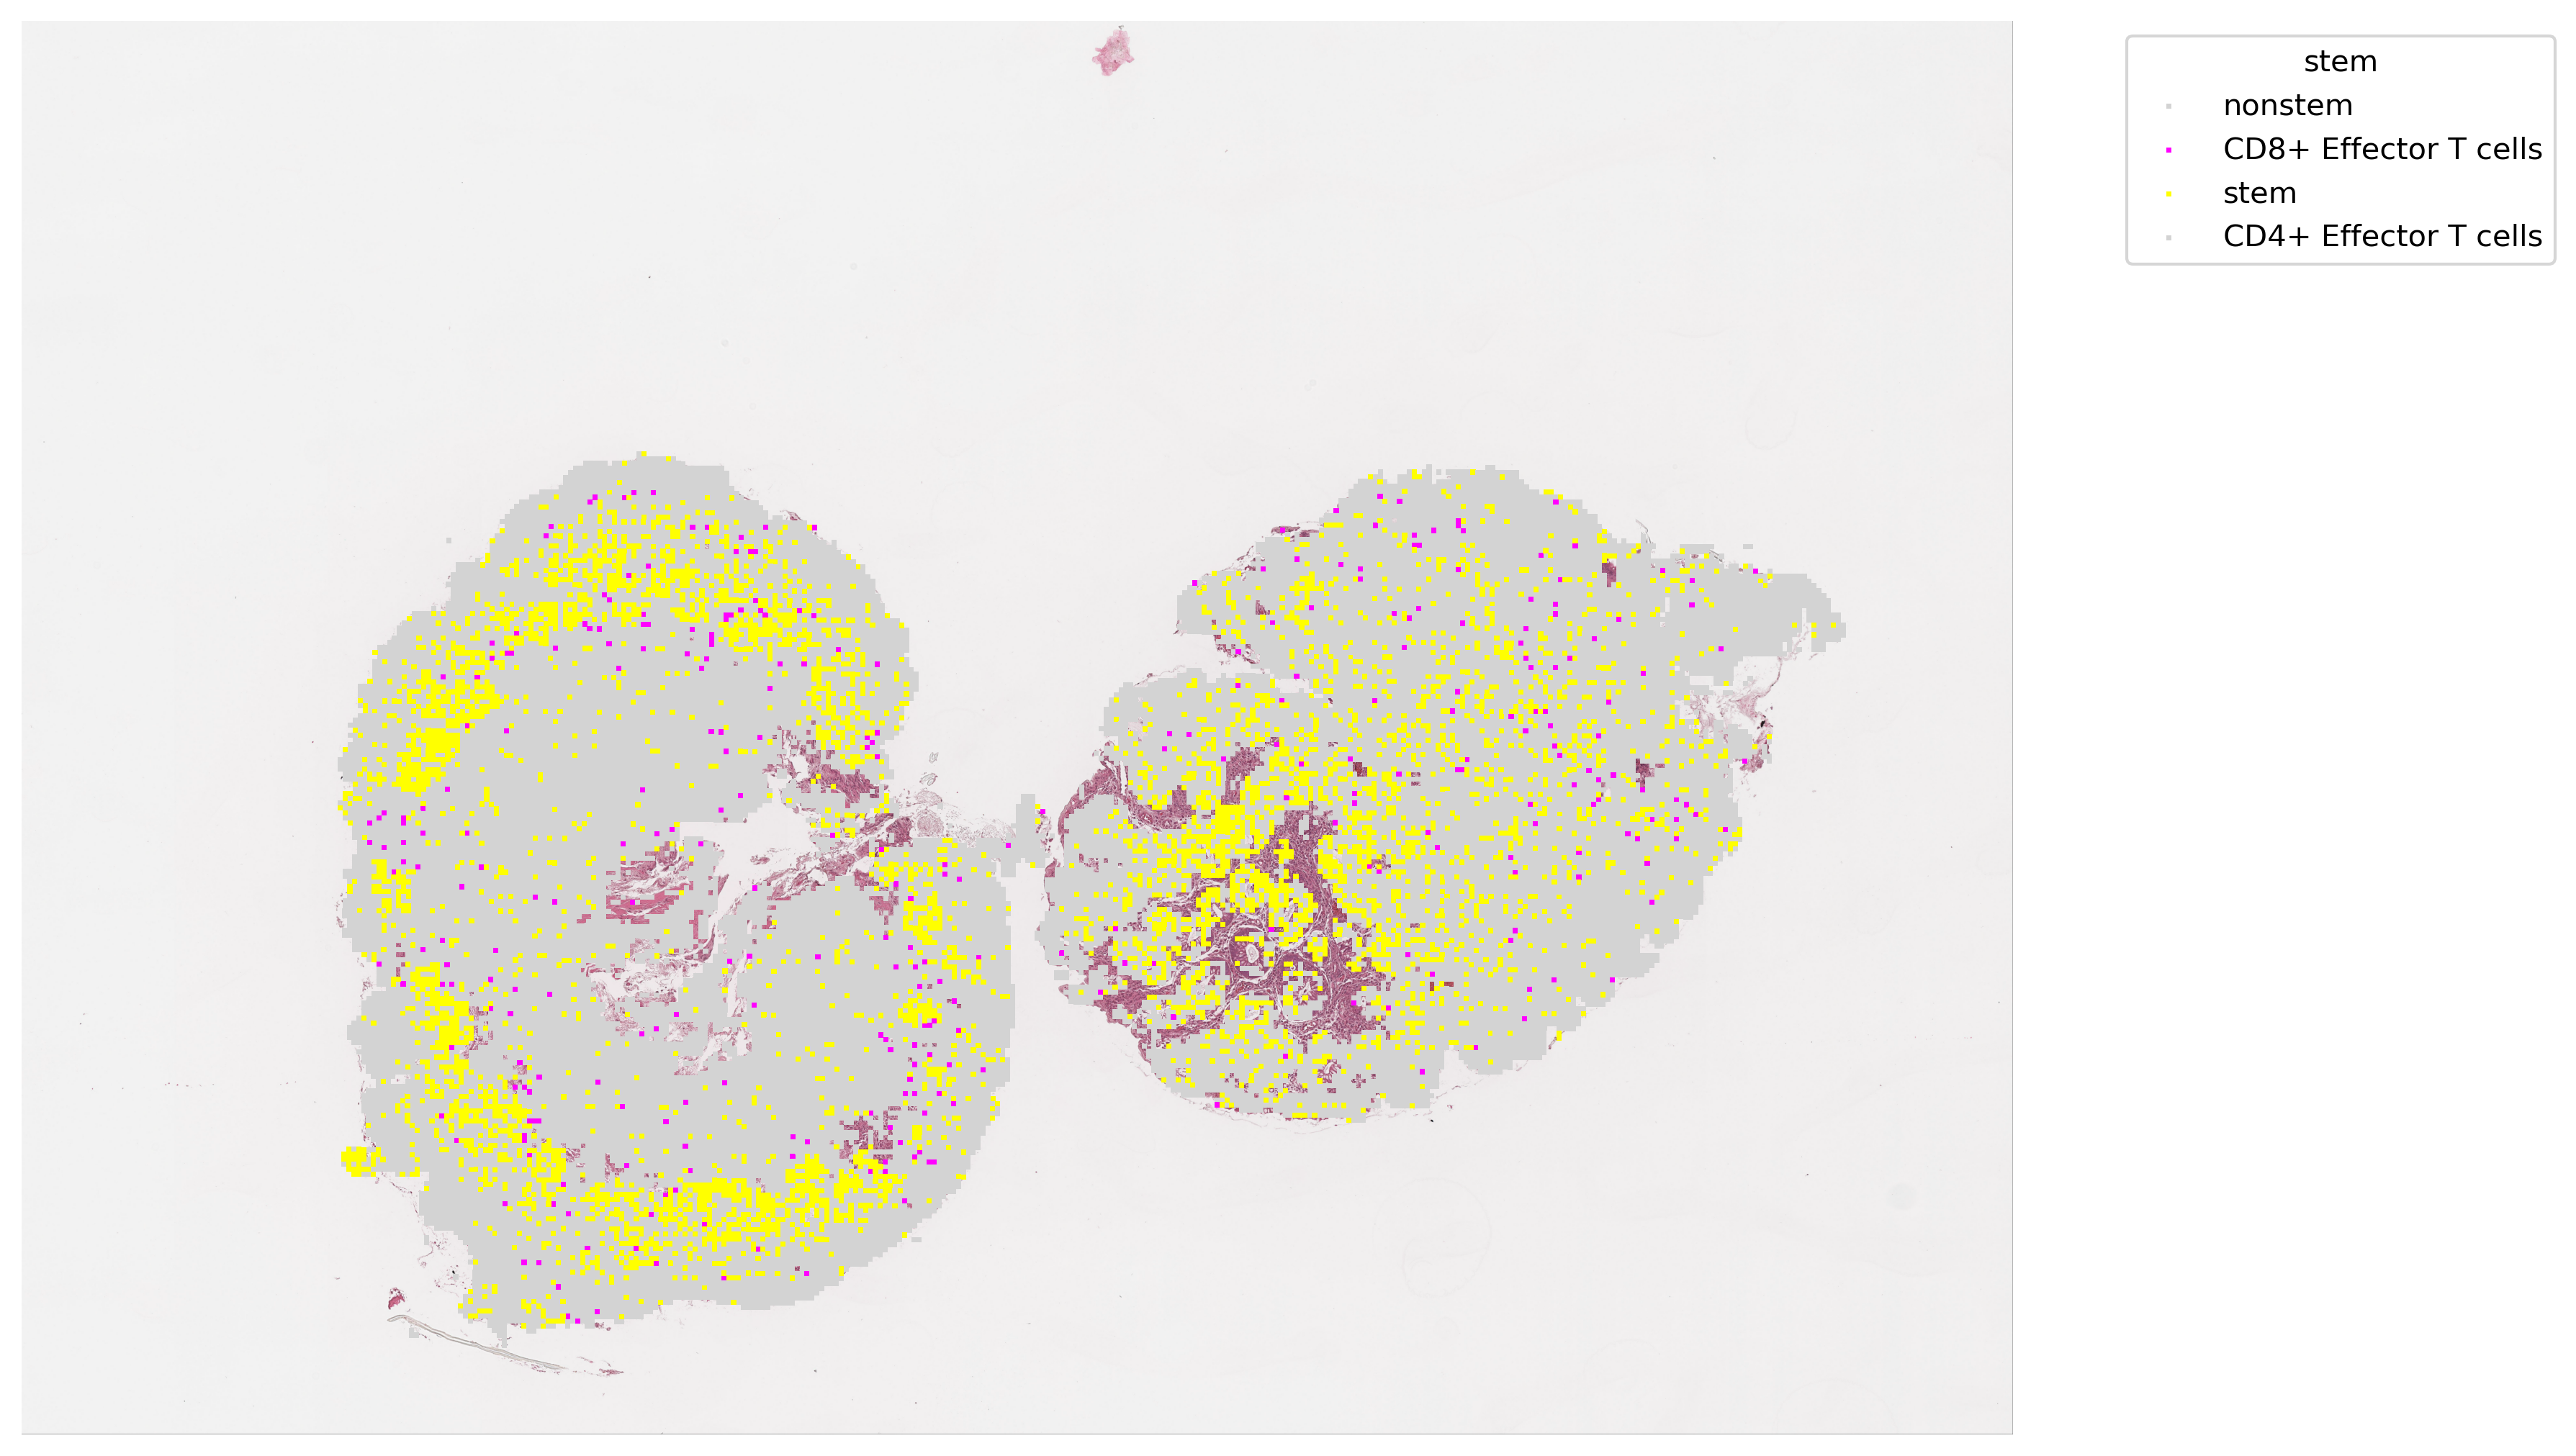

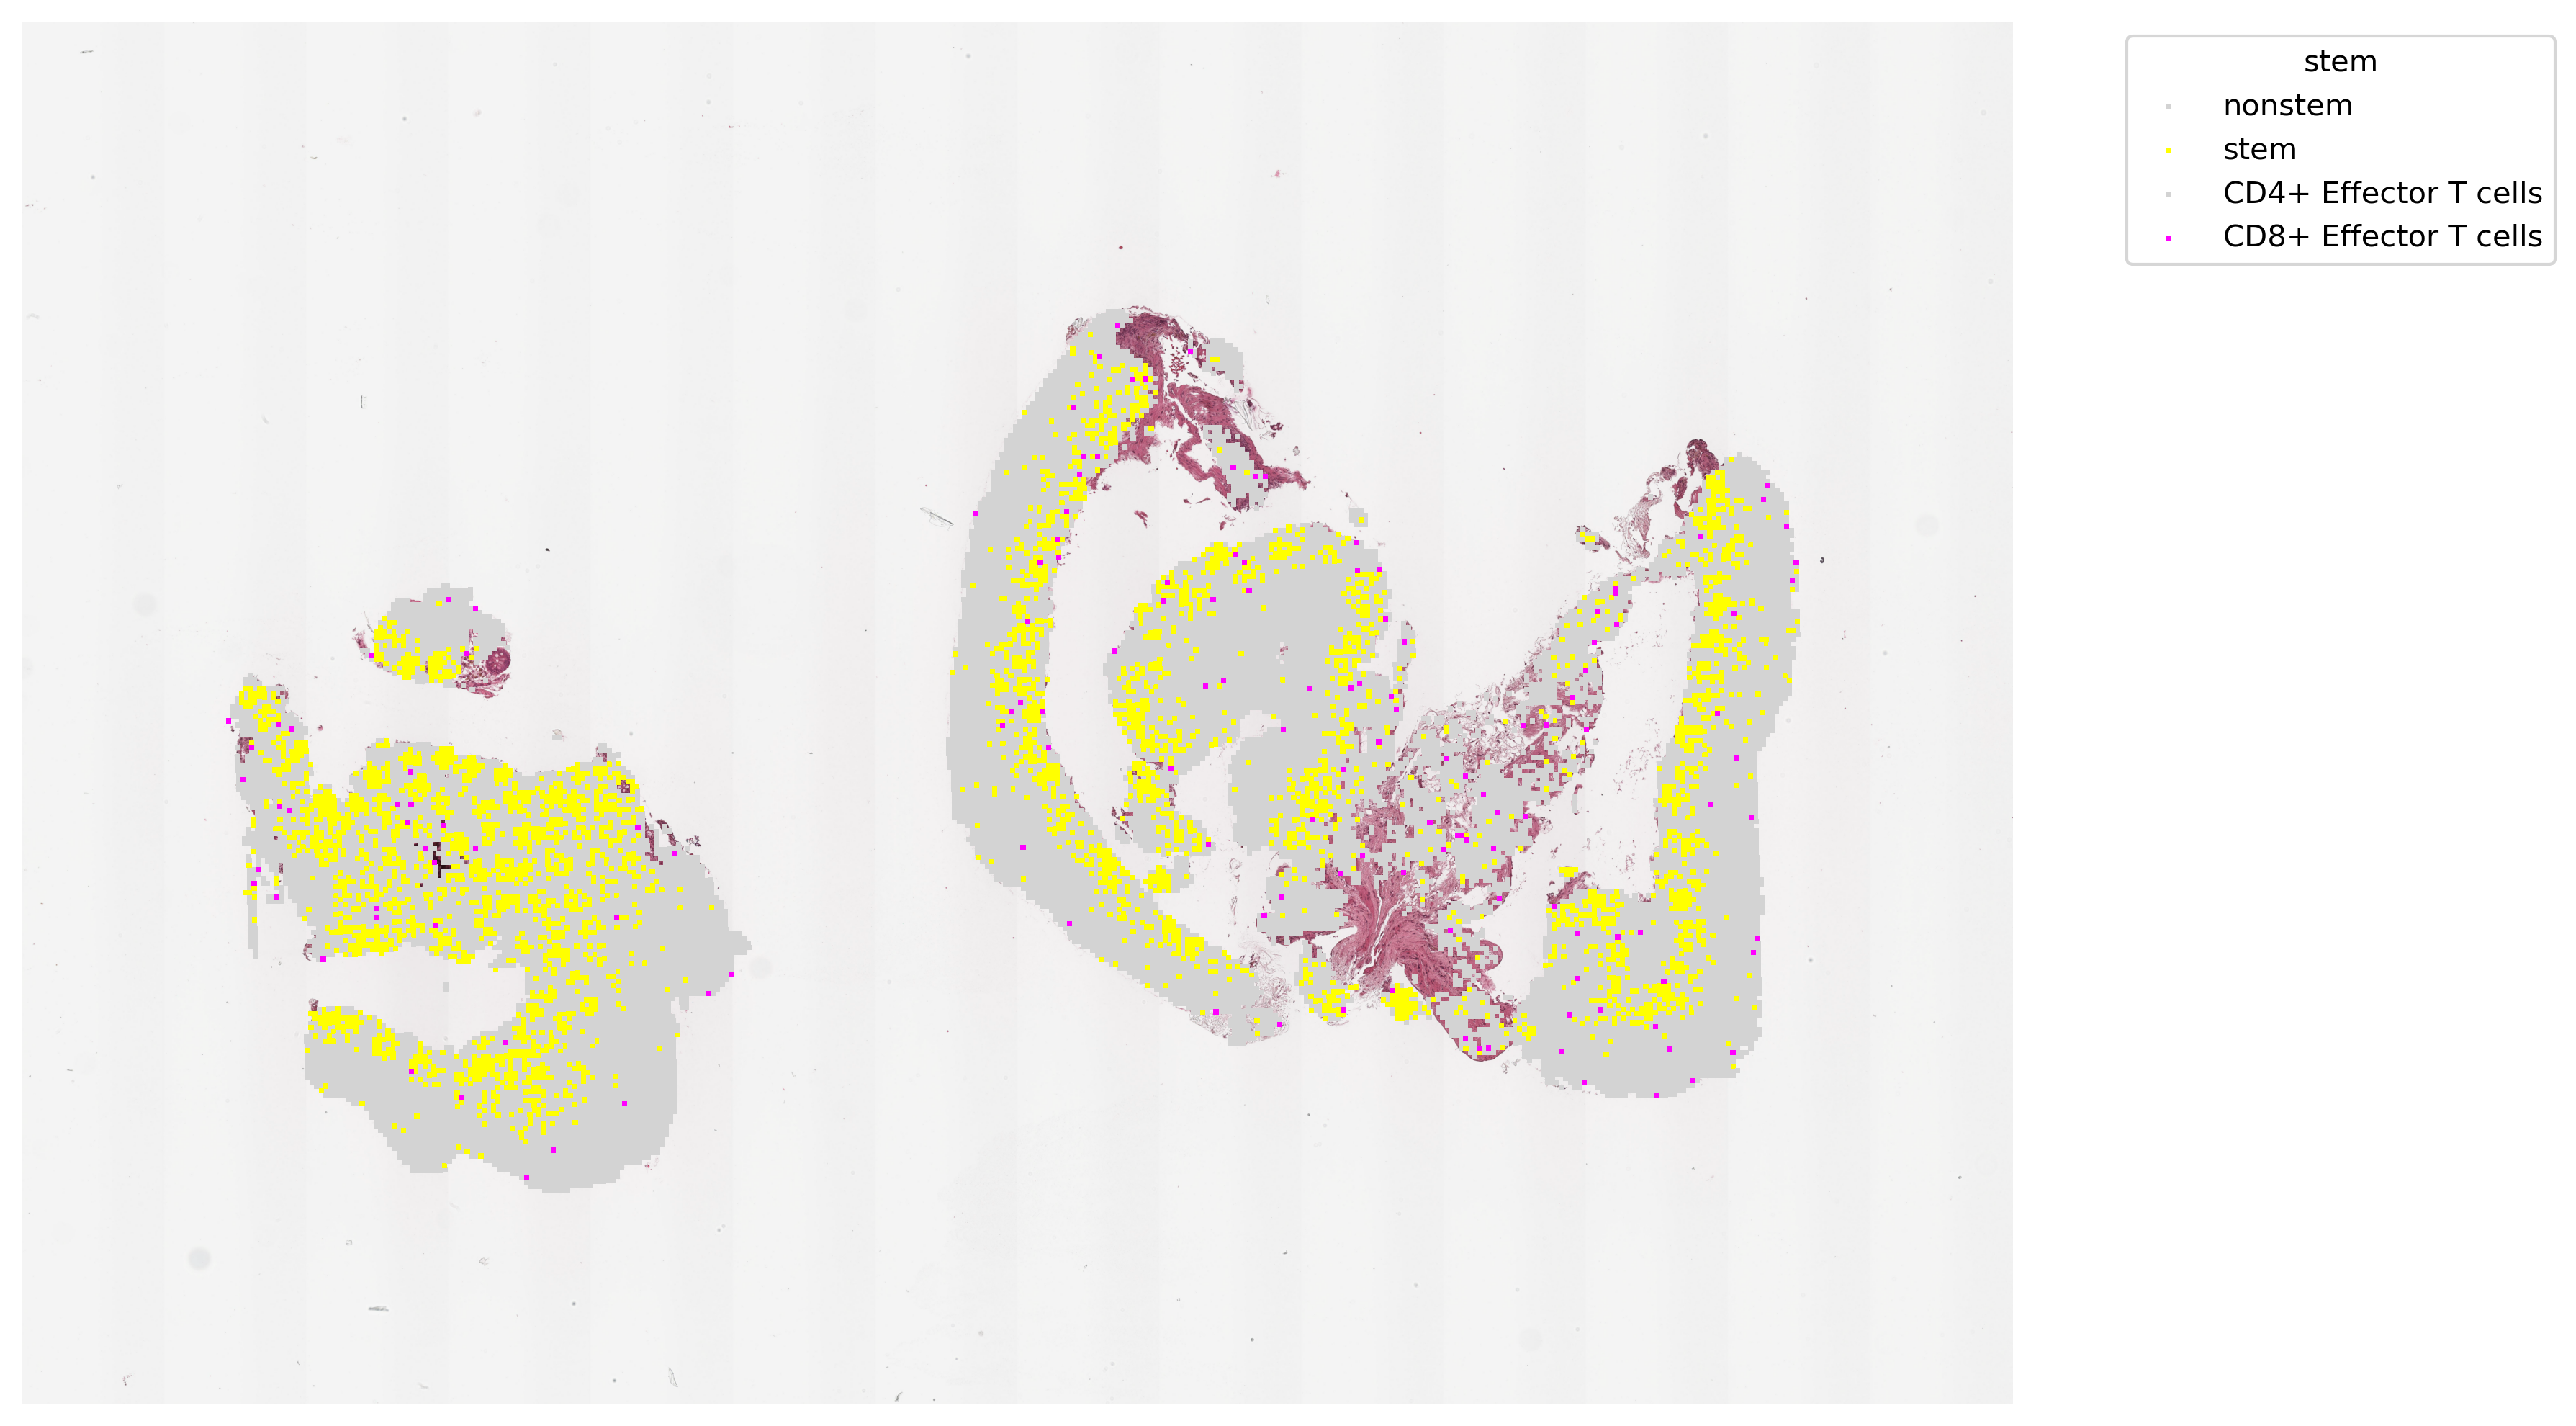

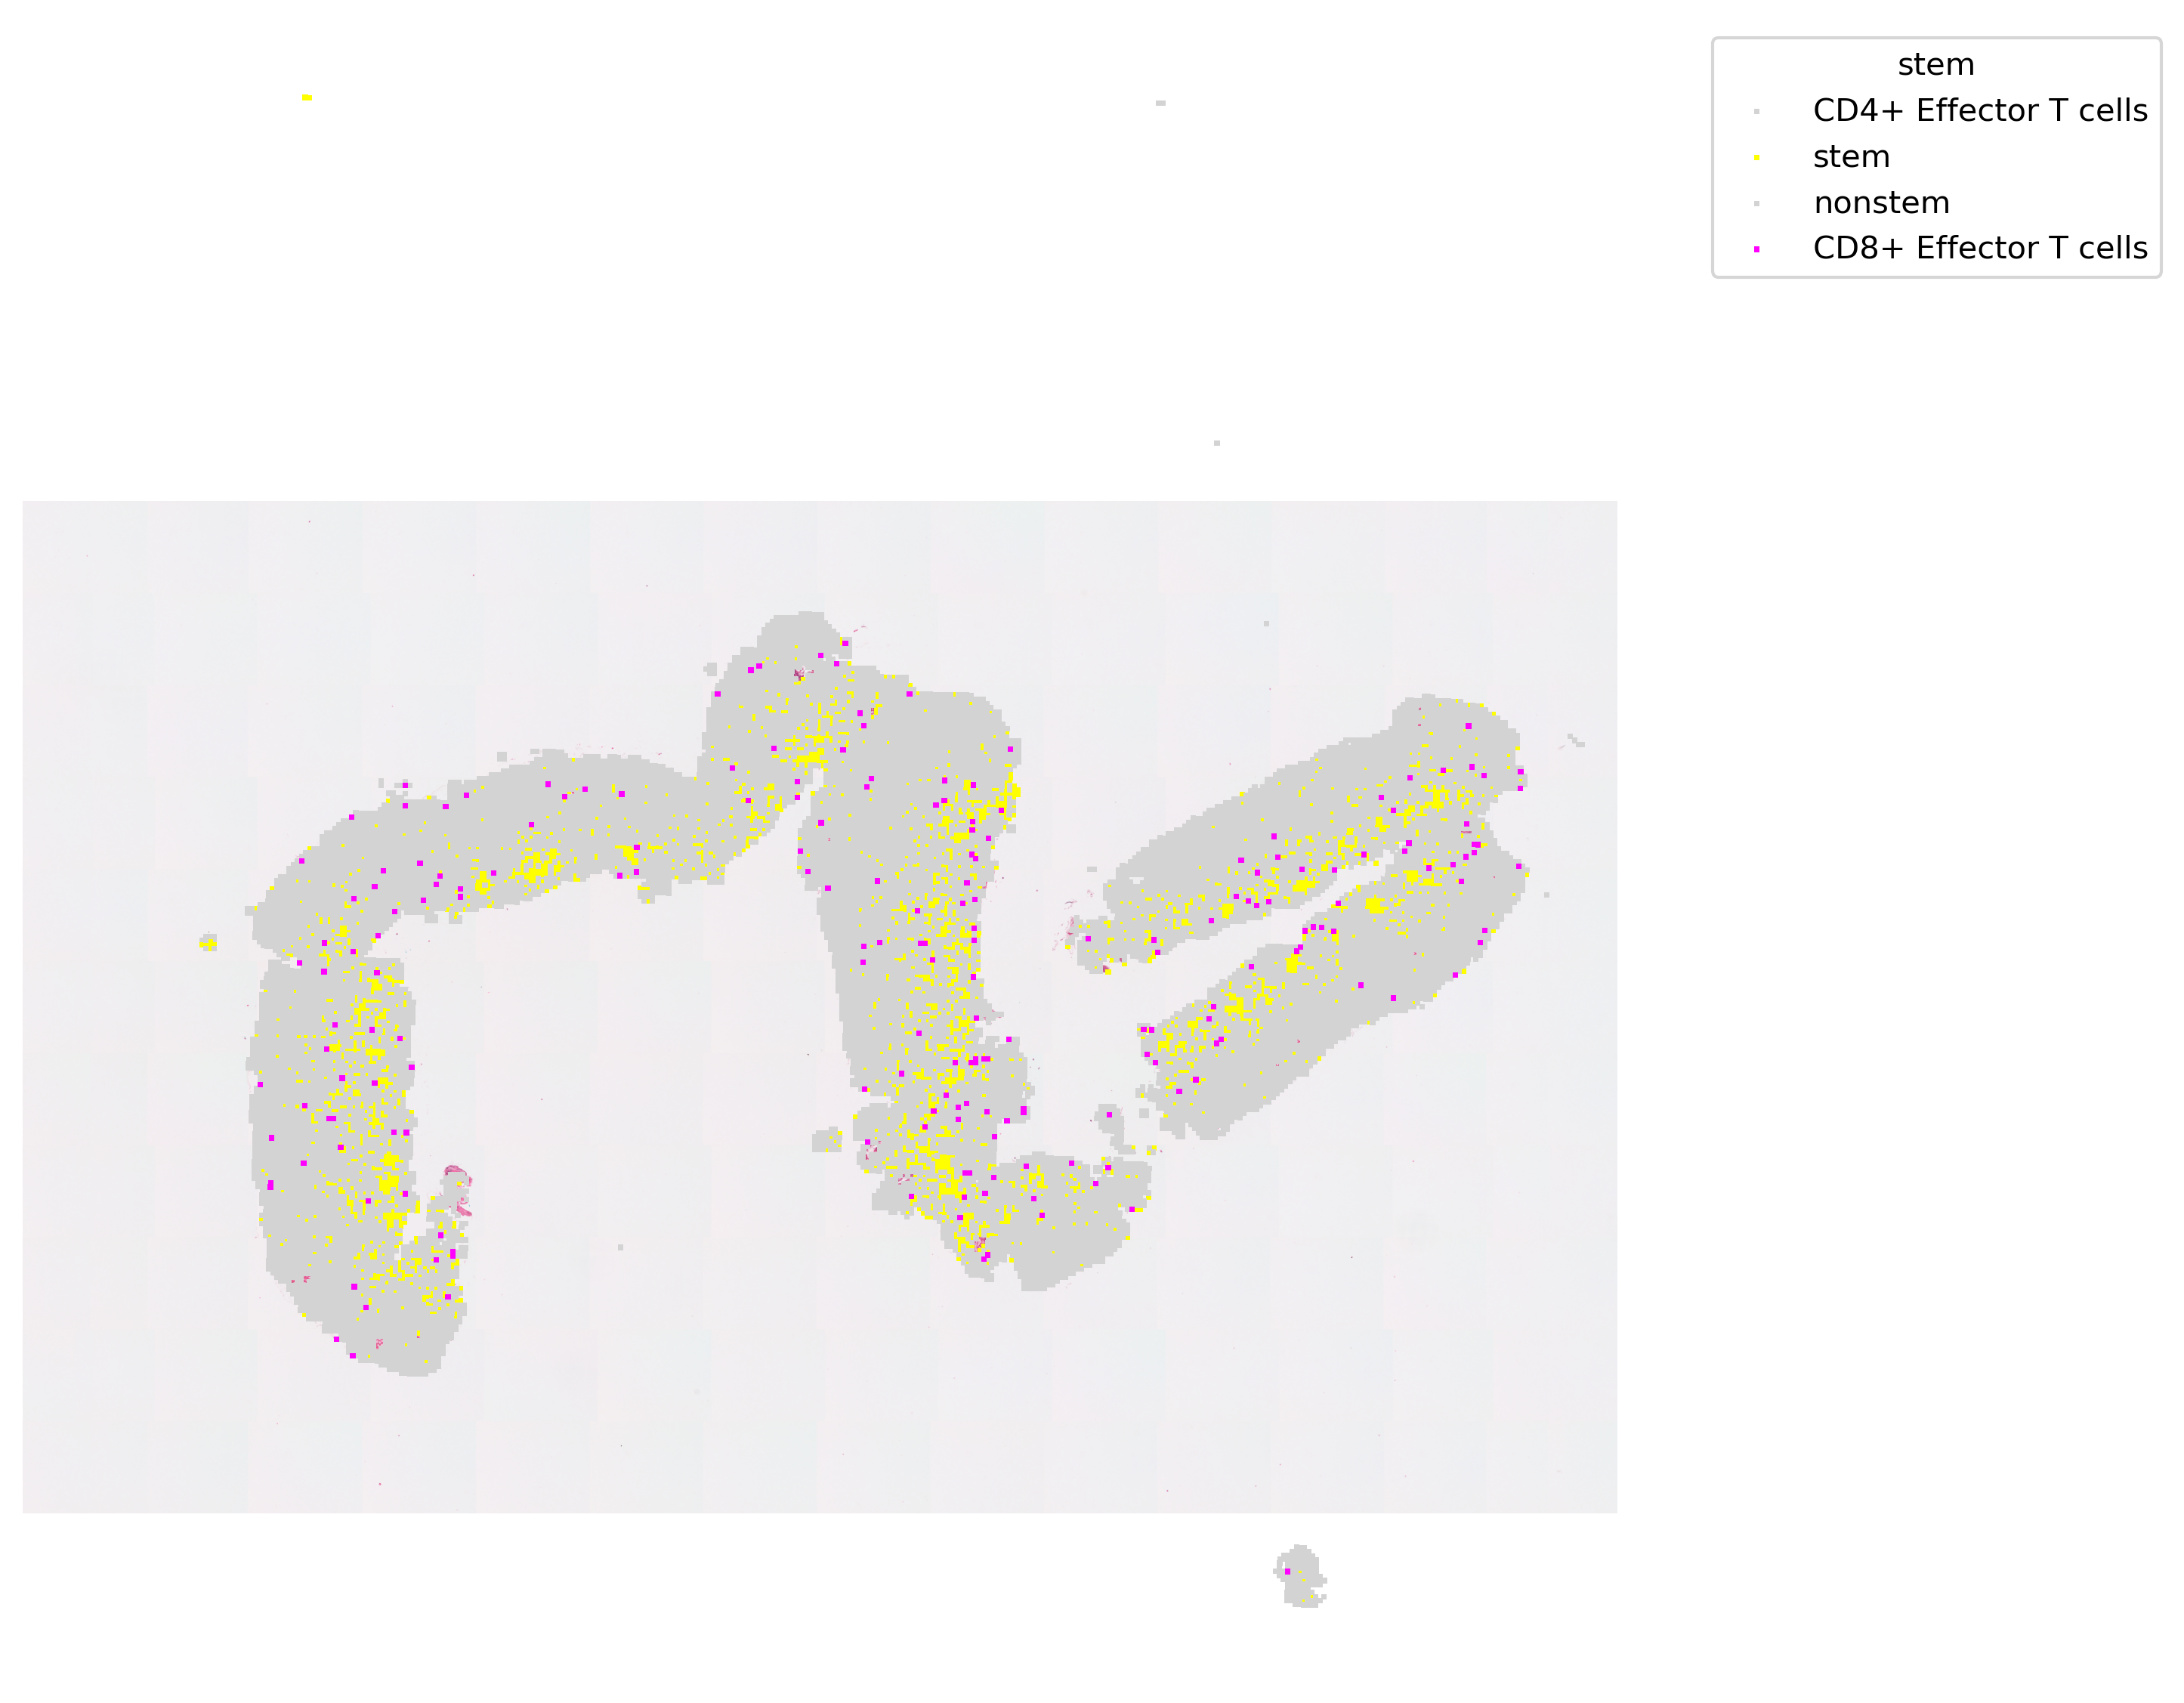

In [25]:
import json
# List of sample IDs
sample_ids = ["SLV14", "SLV16", "SLV17"]  

# Iterate through each sample ID
for sample_id in sample_ids:
    file_path = f'/home/jz3553/data/{sample_id}/scalefactors_json.json'
    his_loc = f'/home/jz3553/data/{sample_id}/tissue_hires_image.png'
    
    # Load the JSON scalefactor file
    with open(file_path, 'r') as file:
        scalefactor = json.load(file)
    
    # Run the function for the given sample
    plot_categories_on_histology(
        adata=adata_integrate[adata_integrate.obs['sample'] == sample_id],
        column='stem',  # Column in adata.obs containing the categories
        his_loc=his_loc,  # Path to the histology image
        scalefactors=scalefactor,
        size=3,
        # output_folder=output_folder,  # Uncomment and replace with your output directory
        sample_id=sample_id, 
        color_map=custom_colors
    )

#### How to quantify spatial colocalization of CD8 and CD4 cells with respect to stem cells? How to statistically test for significance? 
1. Define distance metric (euclidean/geodisc/graph-based dist)
2. Develop a colocalization metric (nearest neighbors/Ripley's K/Moran's I/joint spatial probability density)
3. Statistical testing

In [26]:
sample = "SLV14"
adata = adata_integrate[adata_integrate.obs['sample']==sample]

# Extract spatial coordinates
spatial_coords = adata.obsm['spatial']

# Identify indices for each hub type
stem_hub_idx = np.where(adata.obs['stem'] == 'stem')[0]
cd8_hub_idx = np.where(adata.obs['stem'] == 'CD8+ Effector T cells')[0]
cd4_hub_idx = np.where(adata.obs['stem'] == 'CD4+ Effector T cells')[0]

# Get spatial coordinates for each hub type
stem_coords = spatial_coords[stem_hub_idx]
cd8_coords = spatial_coords[cd8_hub_idx]
cd4_coords = spatial_coords[cd4_hub_idx]

In [27]:
import scipy
# Compute nearest neighbor distances using KDTree
cd8_tree = scipy.spatial.KDTree(cd8_coords)
cd4_tree = scipy.spatial.KDTree(cd4_coords)

# Find the nearest neighbor distance for each stem cell hub
cd8_distances, _ = cd8_tree.query(stem_coords)
cd4_distances, _ = cd4_tree.query(stem_coords)

# Compute difference (CD8+ - CD4+ distance)
delta_d = cd8_distances - cd4_distances

#### Stats Tests
1. Cohen's d = (mu_cd8 - mu_cd4)/ sigma_pooled.
* Therefore, a negative d means mu_cd8 is smaller than mu_cd4, which means closer distance.
* The magnitude suggest a moderate-to-strong effect size.

2. Wilcoxon signed-rank test is a non-parametric test is a non-parametric test that compares paired samples.
* null hypothesis is that CD8+ and CD4+ hub dist wrt stem are not significantly different.
* alternative hypothesis is therefore one is consistently closer to the other.

3.  Permutation t-test is a randomization-based test that helps verify that the observed difference is not due to random chance.
*  If we randomly shuffle the CD8+ and CD4+ hub labels, we should see no systematic difference in distances.
*  The actual observed difference is much greater than what would be expected by random chance.

Shuffle the CD8+ and CD4+ distance labels randomly. Compute the mean difference (Δd) after shuffling. Repeat 1,000+ times to generate a null distribution of Δd. Compare the actual observed Δd with the null distribution.


--- Statistical Results ---
Wilcoxon Test Statistic: 2331268.000
Wilcoxon p-value: 0.00000
Permutation p-value: 0.00000
Cohen's d (effect size): 0.643


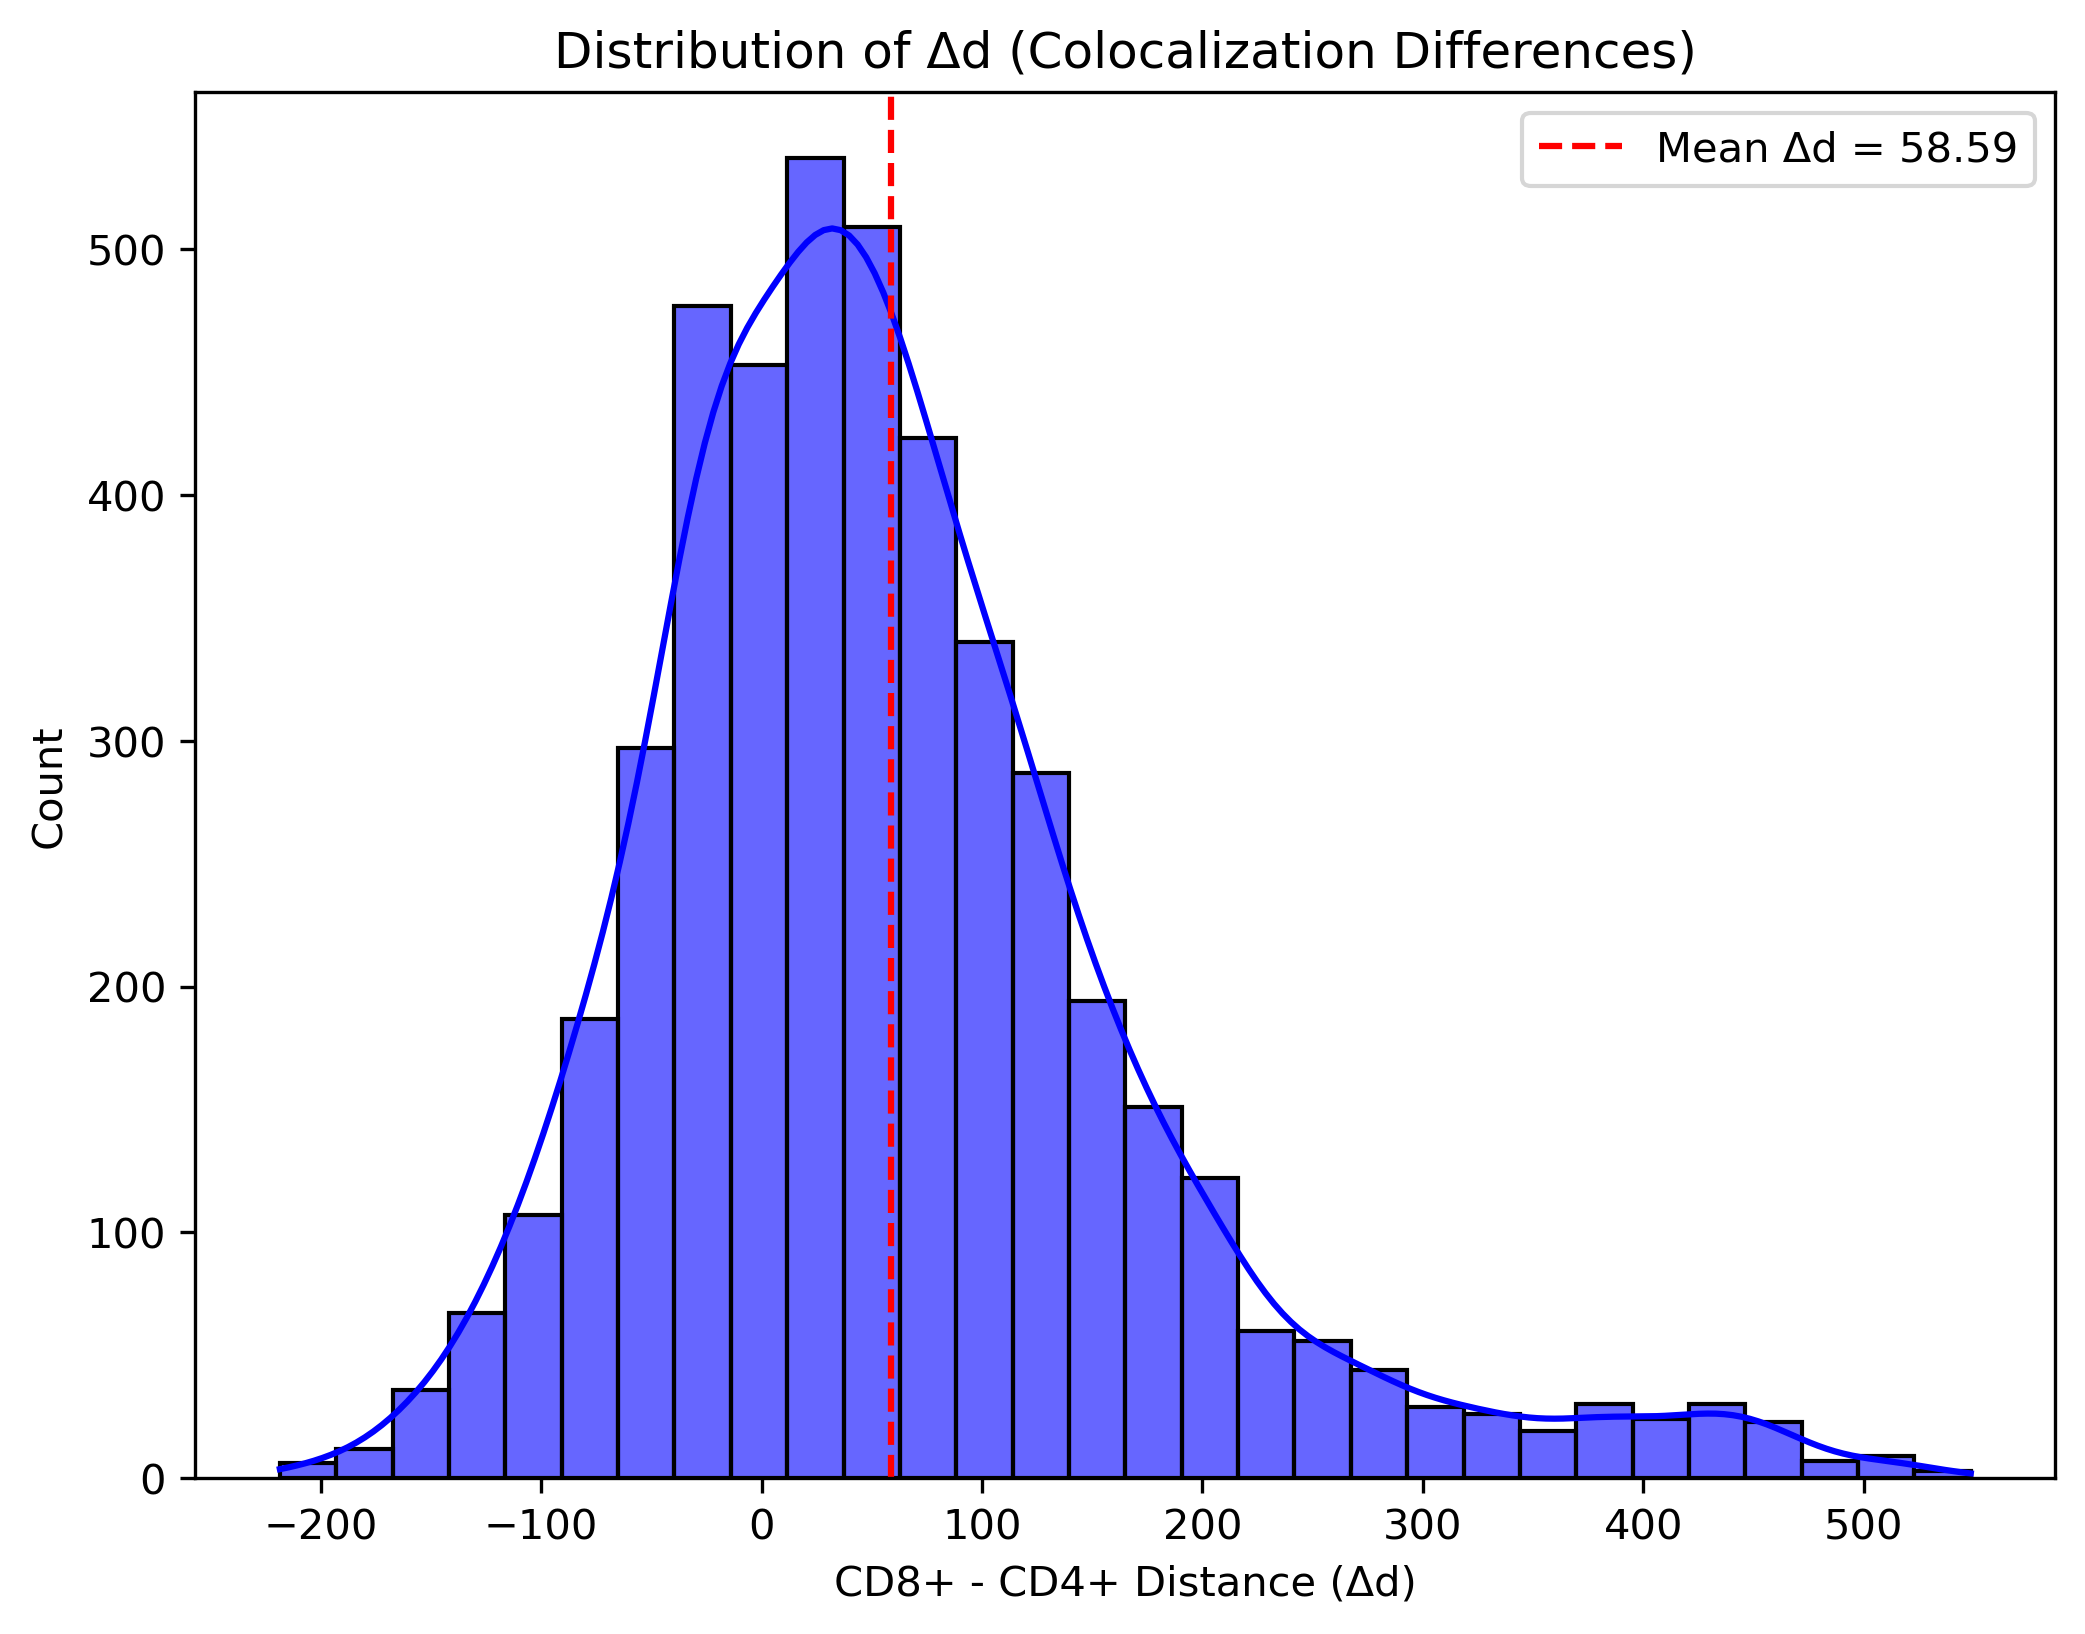

In [28]:
# Perform Wilcoxon signed-rank test
wilcoxon_test = stats.wilcoxon(cd8_distances, cd4_distances)

# Permutation test
num_permutations = 10
perm_deltas = []

for _ in range(num_permutations):
    shuffled_cd8_cd4 = np.random.permutation(np.concatenate([cd8_distances, cd4_distances]))
    shuffled_cd8 = shuffled_cd8_cd4[:len(cd8_distances)]
    shuffled_cd4 = shuffled_cd8_cd4[len(cd8_distances):]
    perm_deltas.append(np.mean(shuffled_cd8 - shuffled_cd4))
    
# Compute p-value from permutation test
perm_p_value = np.mean(np.abs(perm_deltas) >= np.abs(np.mean(delta_d)))

# Compute effect size (Cohen's d)
cohens_d = (np.mean(cd8_distances) - np.mean(cd4_distances)) / np.std(np.concatenate([cd8_distances, cd4_distances]))

# Save results as CSV
results_df = pd.DataFrame({
    "Stem Hub Index": stem_hub_idx,
    "CD8+ Distance": cd8_distances,
    "CD4+ Distance": cd4_distances,
    "Delta Distance": delta_d
})
# results_df.to_csv("colocalization_results.csv", index=False)

# Display summary results
print("\n--- Statistical Results ---")
print(f"Wilcoxon Test Statistic: {wilcoxon_test.statistic:.3f}")
print(f"Wilcoxon p-value: {wilcoxon_test.pvalue:.5f}")
print(f"Permutation p-value: {perm_p_value:.5f}")
print(f"Cohen's d (effect size): {cohens_d:.3f}")

# Visualization: Histogram of Distance Differences
import seaborn as sns
plt.figure(figsize=(8,6))
sns.histplot(delta_d, kde=True, bins=30, color="blue", alpha=0.6)
plt.axvline(x=np.mean(delta_d), color='red', linestyle='dashed', label=f"Mean Δd = {np.mean(delta_d):.2f}")
plt.xlabel("CD8+ - CD4+ Distance (Δd)")
plt.ylabel("Count")
plt.title("Distribution of Δd (Colocalization Differences)")
plt.legend()
plt.savefig("colocalization_histogram.png", dpi=300)  # Save plot as PNG
plt.show()

#### Comparing between grades of GVHD: CD8+ colocalization with stem cells 

In [31]:
# import numpy as np
# import pandas as pd
# import scipy.spatial

# def compute_nndistance(adata, cell_type1, cell_type2, sample_id):
#     """
#     Computes nearest neighbor distance between cell_type1 and the closest cell_type2 in a given sample.
#     Optimized for speed using batch filtering and KDTree indexing.
#     """
#     # Extract spatial coordinates
#     spatial_coords = adata.obsm['spatial']

#     # Filter indices using NumPy for faster lookup
#     sample_mask = (adata.obs['sample'].to_numpy() == sample_id)
#     cell1_mask = (adata.obs['stem'].to_numpy() == cell_type1) & sample_mask
#     cell2_mask = (adata.obs['stem'].to_numpy() == cell_type2) & sample_mask

#     # Extract spatial coordinates
#     cell1_coords = spatial_coords[cell1_mask]
#     cell2_coords = spatial_coords[cell2_mask]

#     # Ensure there are enough points
#     if len(cell1_coords) == 0 or len(cell2_coords) == 0:
#         raise ValueError(f"Not enough {cell_type1} or {cell_type2} cells in sample {sample_id}.")

#     # **OPTIMIZATION: Use BallTree instead of KDTree for better performance**
#     tree = scipy.spatial.cKDTree(cell2_coords)
#     nnd, _ = tree.query(cell1_coords, workers=-1)  # Uses parallel processing

#     return nnd

In [45]:
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.stats as stats
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


# Function to compare NND between two samples
def compare_nnd_between_samples(nnd_sample1, nnd_sample2, label1, label2):
    """
    Performs statistical comparison of nearest neighbor distances between two samples.

    Parameters:
        nnd_sample1 (np.array): Nearest neighbor distances for sample 1.
        nnd_sample2 (np.array): Nearest neighbor distances for sample 2.
        label1 (str): Label for sample 1 (e.g., 'SLV14').
        label2 (str): Label for sample 2 (e.g., 'SLV16').

    Returns:
        dict: Statistical test results (Wilcoxon p-value, Cohen’s d, means).
    """

    # Perform Wilcoxon rank-sum test
    wilcoxon_test = stats.mannwhitneyu(nnd_sample1, nnd_sample2, alternative='two-sided')

    # Compute Cohen's d
    mean1, mean2 = np.mean(nnd_sample1), np.mean(nnd_sample2)
    std_pooled = np.sqrt((np.var(nnd_sample1, ddof=1) + np.var(nnd_sample2, ddof=1)) / 2)
    cohens_d = (mean1 - mean2) / std_pooled

    # Visualization
    results_df = pd.DataFrame({
        "Sample": [label1] * len(nnd_sample1) + [label2] * len(nnd_sample2),
        "NND": np.concatenate([nnd_sample1, nnd_sample2])
    })

    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Sample", y="NND", data=results_df, palette=["red", "blue"])
    sns.swarmplot(x="Sample", y="NND", data=results_df, color="black", alpha=0.6)
    plt.xlabel("GVHD Sample")
    plt.ylabel("Nearest Neighbor Distance (NND)")
    plt.title(f"NND Comparison: {label1} vs. {label2}")
    plt.axhline(y=mean1, color="red", linestyle="dashed", label=f"{label1} Mean: {mean1:.2f}")
    plt.axhline(y=mean2, color="blue", linestyle="dashed", label=f"{label2} Mean: {mean2:.2f}")
    plt.legend()
    plt.savefig(f"nnd_comparison_{label1}_vs_{label2}.png", dpi=300)
    plt.show()

    # Output results
    return {
        "Wilcoxon Test Statistic": wilcoxon_test.statistic,
        "Wilcoxon p-value": wilcoxon_test.pvalue,
        "Cohen's d": cohens_d,
        f"Mean NND {label1}": mean1,
        f"Mean NND {label2}": mean2
    }

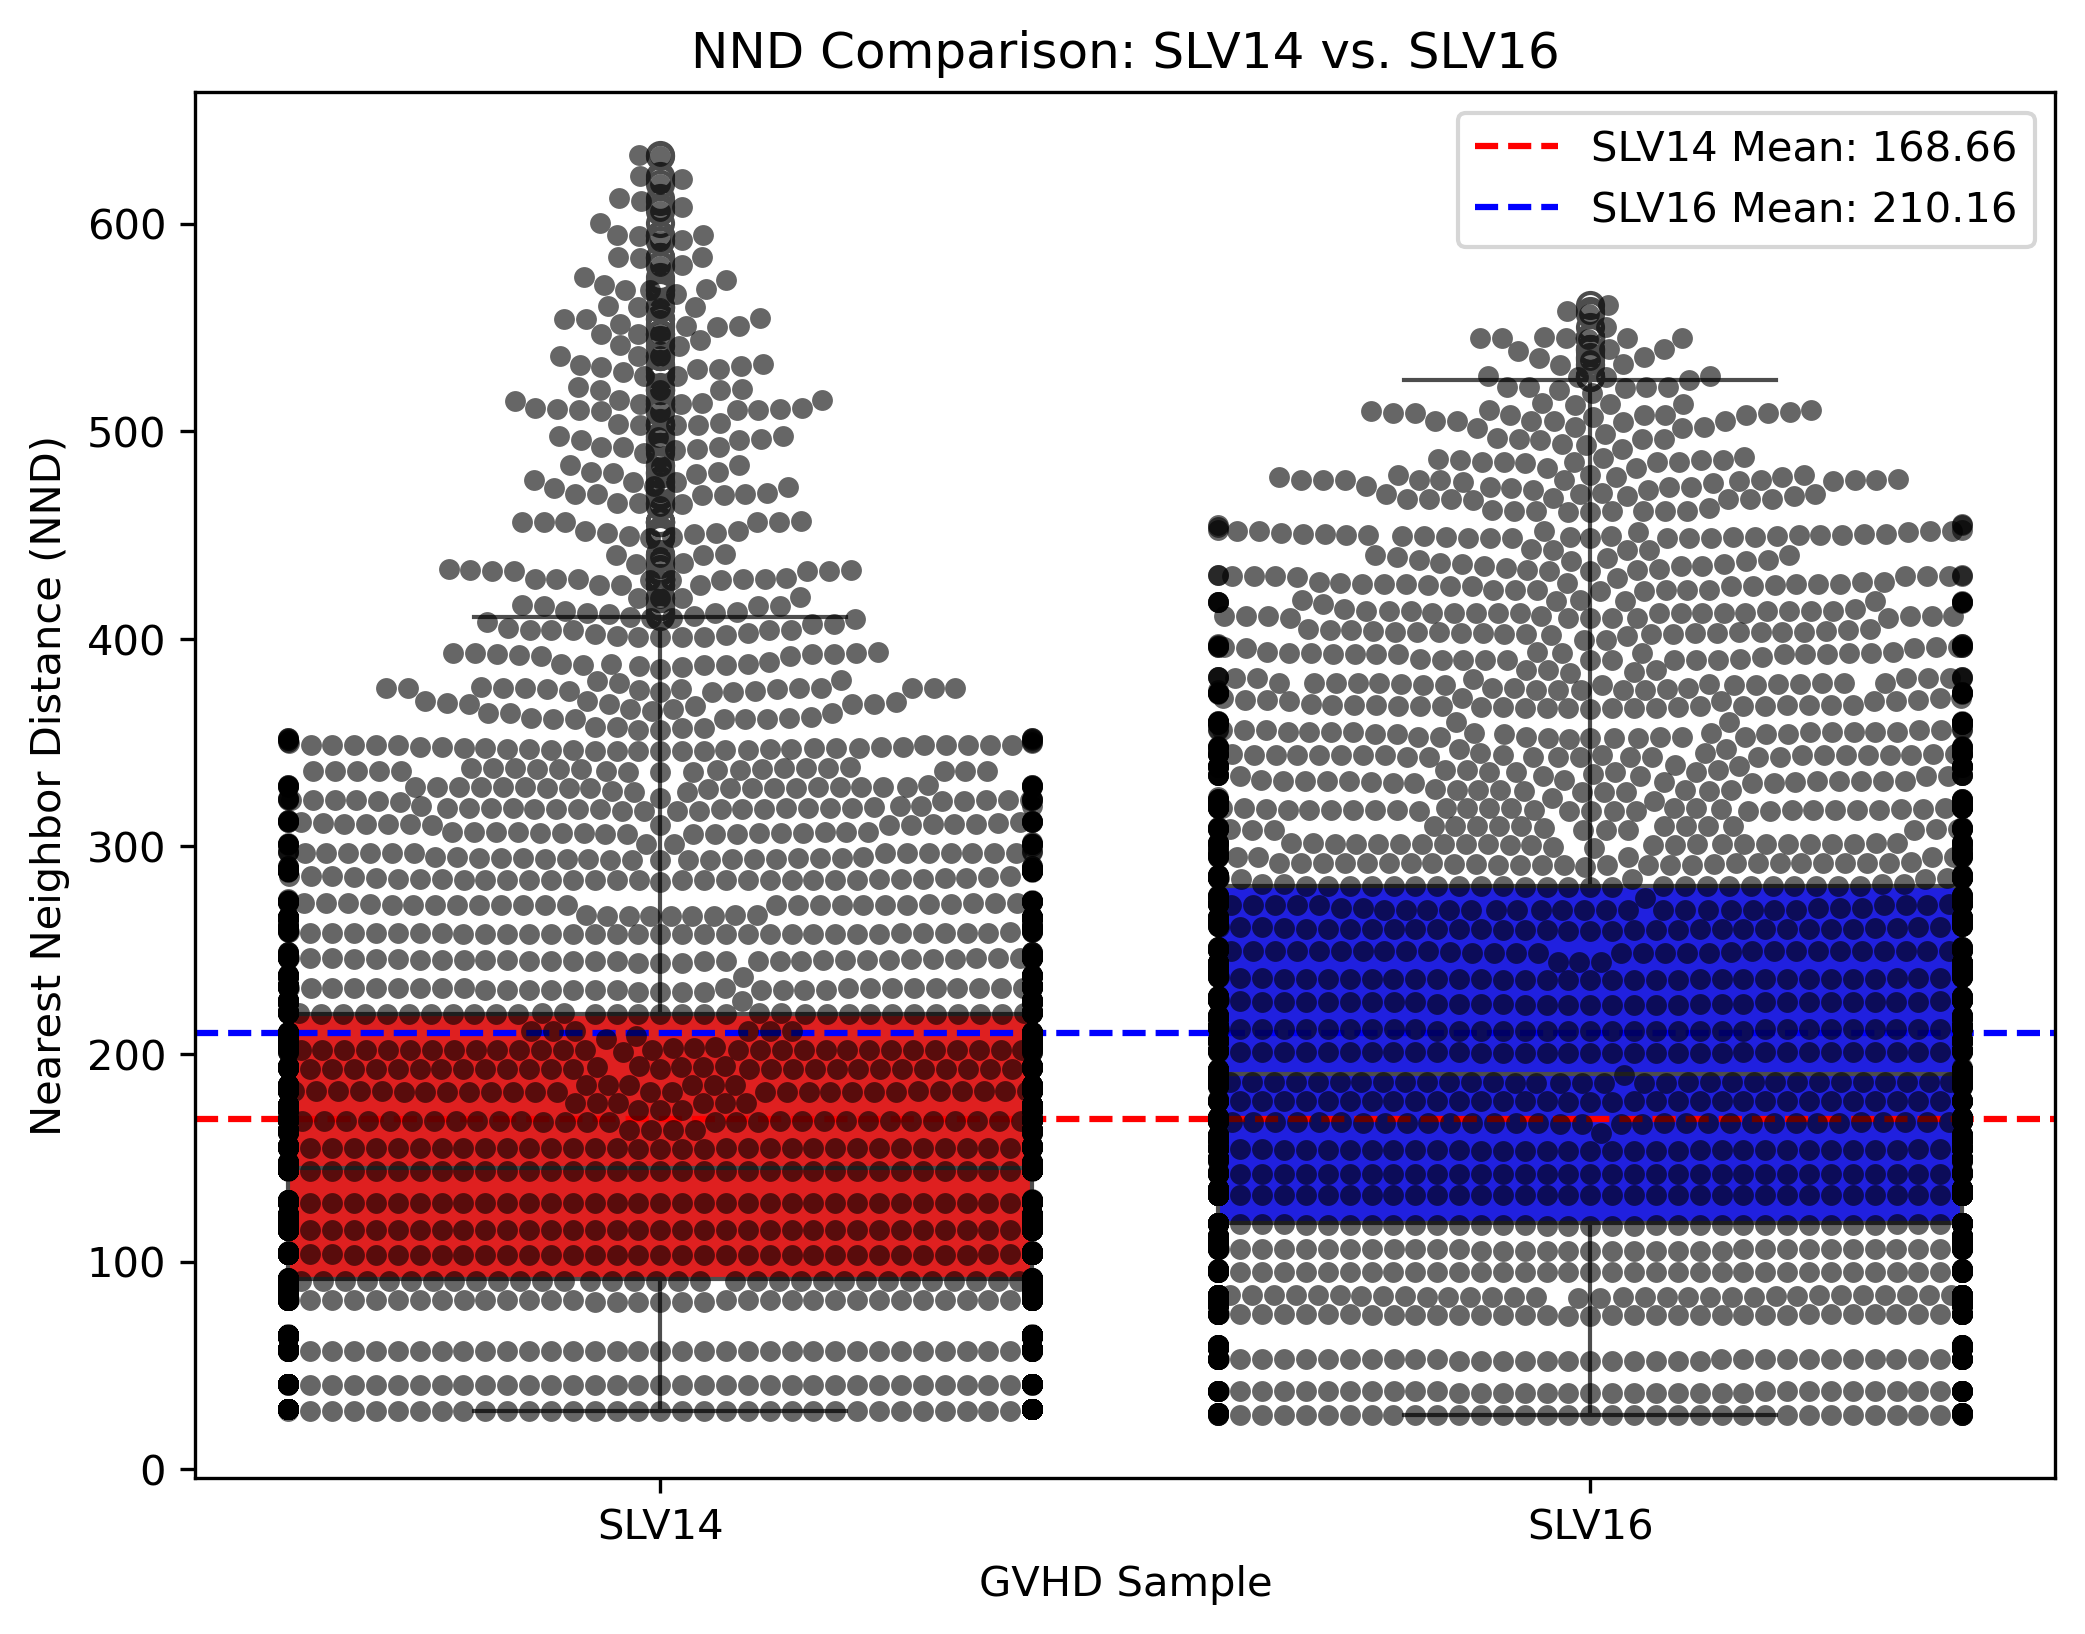


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 6469114.50000
Wilcoxon p-value: 0.00000
Cohen's d: -0.37501
Mean NND SLV14: 168.66357
Mean NND SLV16: 210.16102


In [33]:
# Compute NND for SLV14 and SLV16
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV14")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV16")

# Compare NND between SLV14 and SLV16
results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV14", label2="SLV16")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

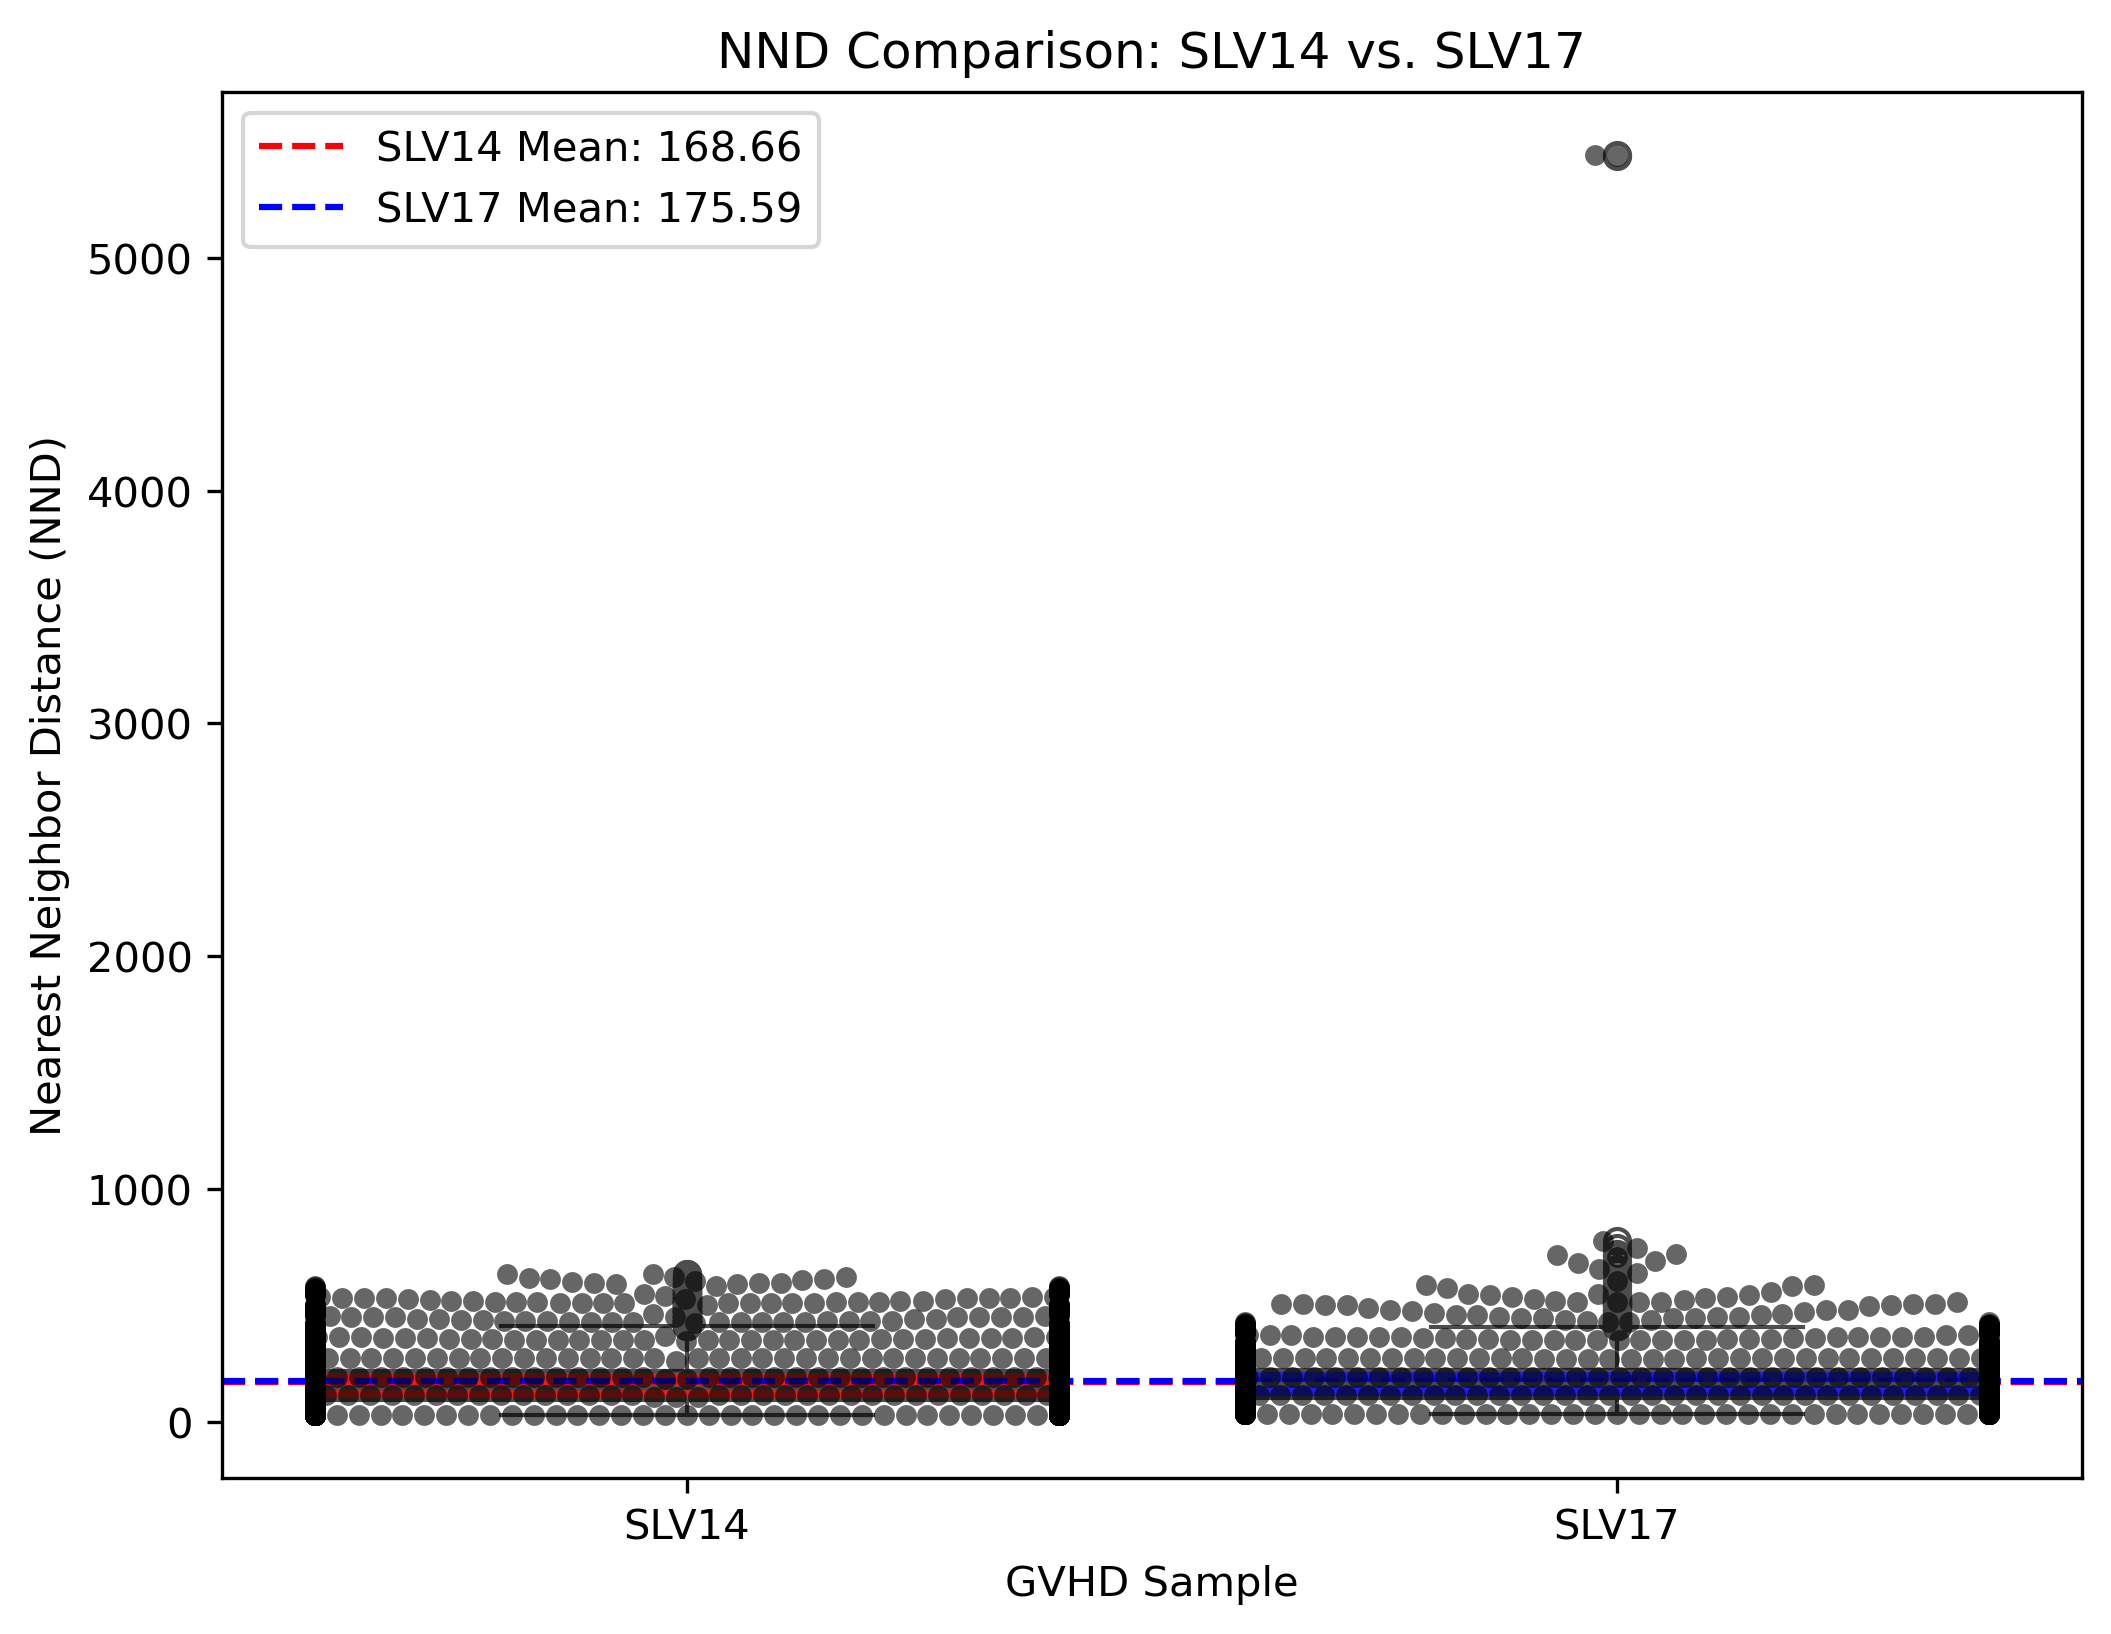


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 5779991.50000
Wilcoxon p-value: 0.00680
Cohen's d: -0.04786
Mean NND SLV14: 168.66357
Mean NND SLV17: 175.59492


In [34]:
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV14")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV17")

results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV14", label2="SLV17")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

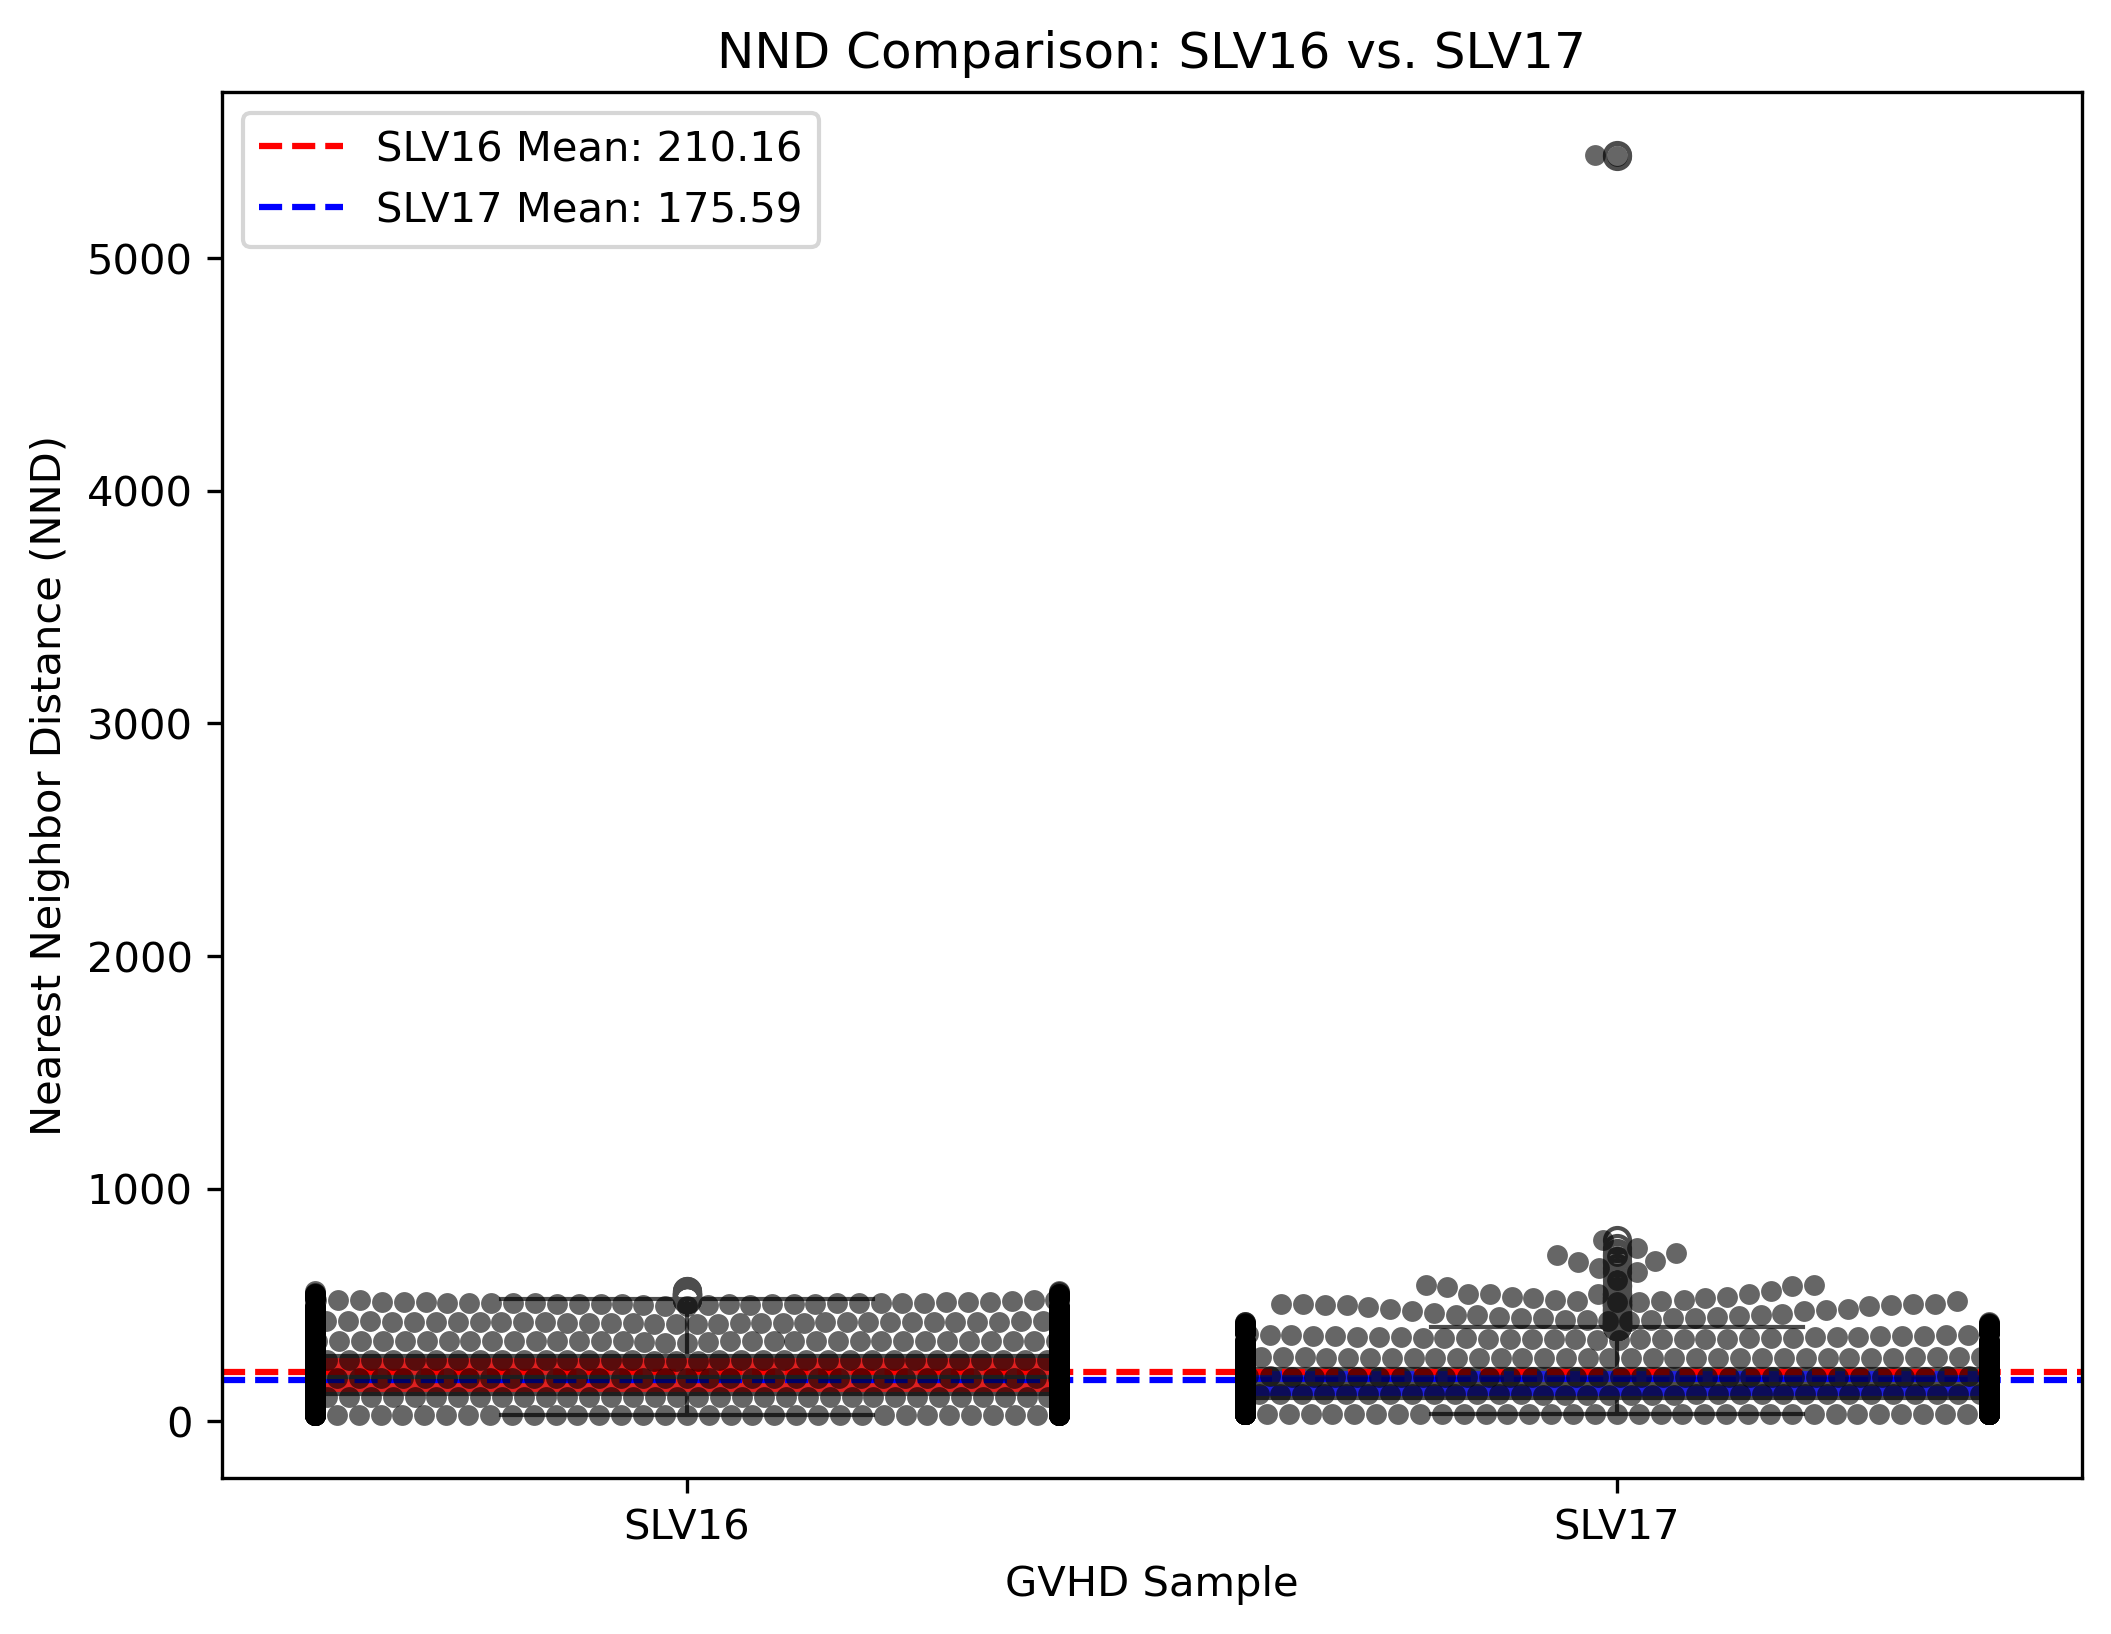


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 5733456.50000
Wilcoxon p-value: 0.00000
Cohen's d: 0.23151
Mean NND SLV16: 210.16102
Mean NND SLV17: 175.59492


In [35]:
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV16")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="stem", cell_type2="CD8+ Effector T cells", sample_id="SLV17")

results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV16", label2="SLV17")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

In [51]:
import numpy as np
import pandas as pd
import scipy.spatial
from sklearn.neighbors import BallTree

def compute_nndistance(adata, cell_type1, cell_type2, sample_id):
    """
    Computes nearest neighbor distance between cell_type1 and the closest cell_type2 in a given sample.
    Converts pixel distances to microns using sample-specific scaling factors.
    """
    spatial_coords = adata.obsm['spatial']
    
    # Retrieve scaling factor correctly
    scalefactors = adata.uns['spatial'].get(sample_id, {}).get('scalefactors', {})
    
    # Check if sample-specific scaling factor exists
    if sample_id not in scalefactors:
        raise KeyError(f"Sample {sample_id} not found in scalefactors. Available samples: {scalefactors.keys()}")

    microns_per_pixel = scalefactors[sample_id].get('microns_per_pixel', None)

    if microns_per_pixel is None:
        raise KeyError(f"'microns_per_pixel' not found for sample {sample_id}. Available keys: {scalefactors[sample_id].keys()}")

    # Optimized NumPy-based filtering
    sample_mask = (adata.obs['sample'].to_numpy() == sample_id)
    cell1_mask = (adata.obs['stem'].to_numpy() == cell_type1) & sample_mask
    cell2_mask = (adata.obs['stem'].to_numpy() == cell_type2) & sample_mask

    cell1_coords = spatial_coords[cell1_mask]
    cell2_coords = spatial_coords[cell2_mask]

    if len(cell1_coords) == 0 or len(cell2_coords) == 0:
        return np.array([])  # Return empty array instead of raising an error

    # Use BallTree for nearest neighbor search
    tree = BallTree(cell2_coords)
    nnd, _ = tree.query(cell1_coords, k=1)  # k=1 for nearest neighbor

    # Convert distances from pixels to microns
    return nnd.flatten() * microns_per_pixel

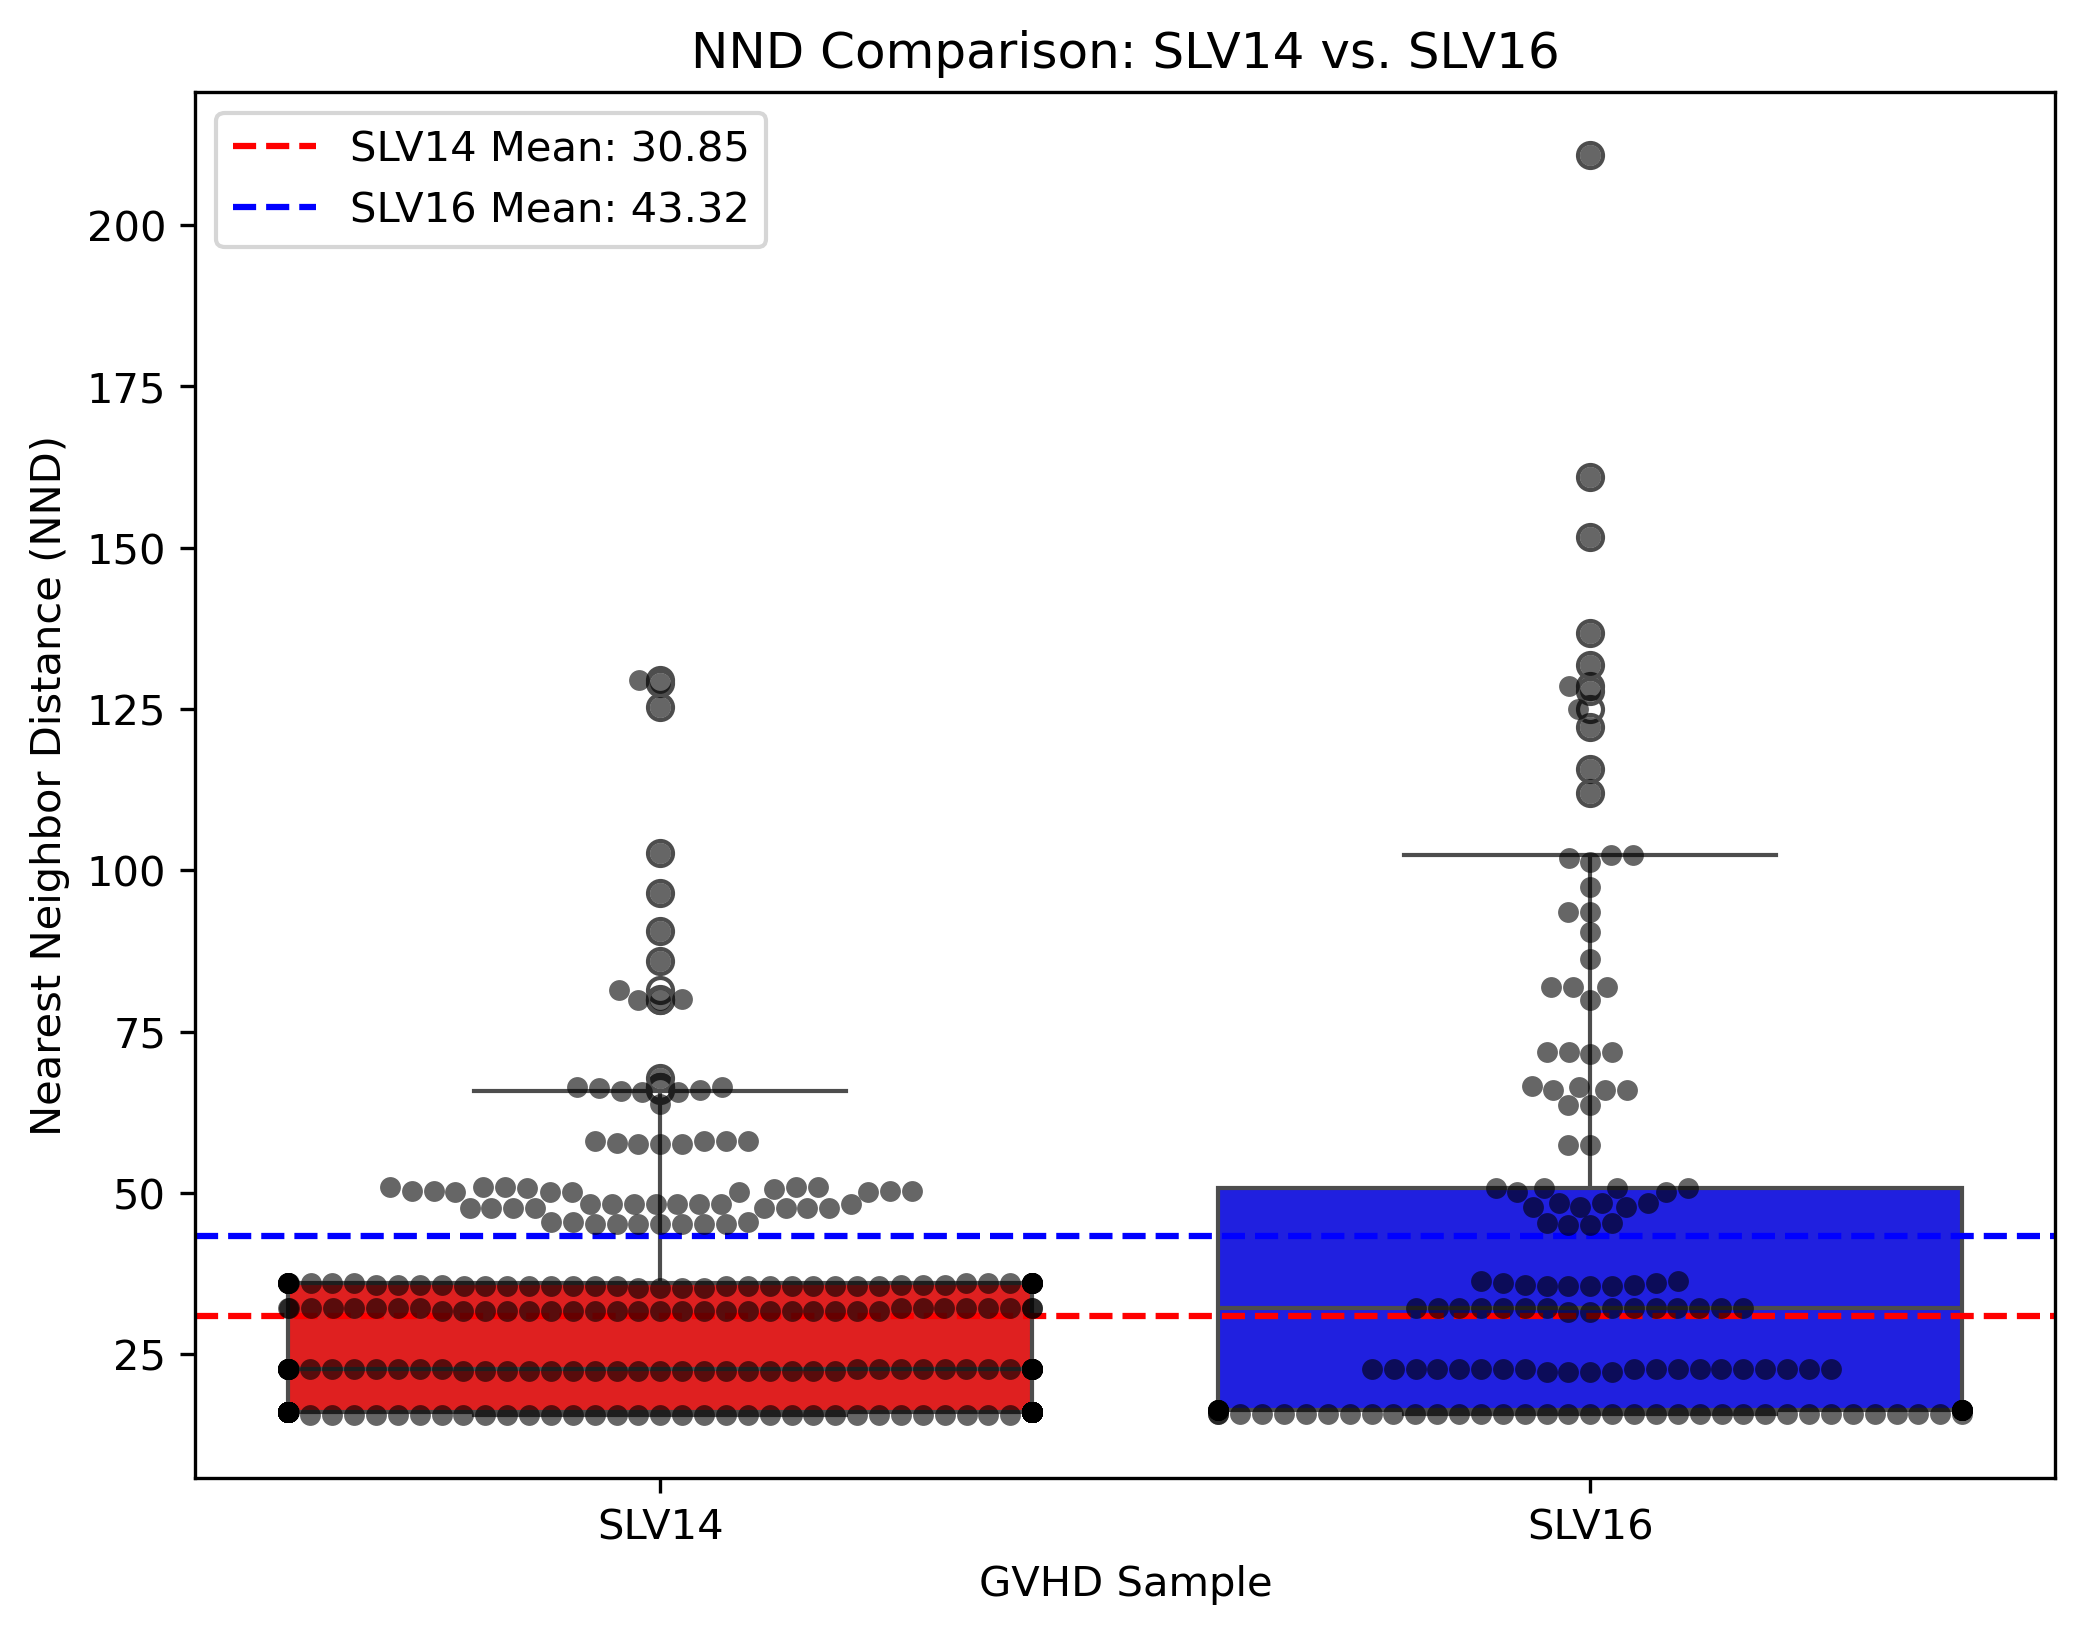


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 22264.00000
Wilcoxon p-value: 0.03955
Cohen's d: -0.43310
Mean NND SLV14: 30.85080
Mean NND SLV16: 43.32312


In [52]:
# Compute NND for SLV14 and SLV16
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV14")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV16")

# Compare NND between SLV14 and SLV16
results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV14", label2="SLV16")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

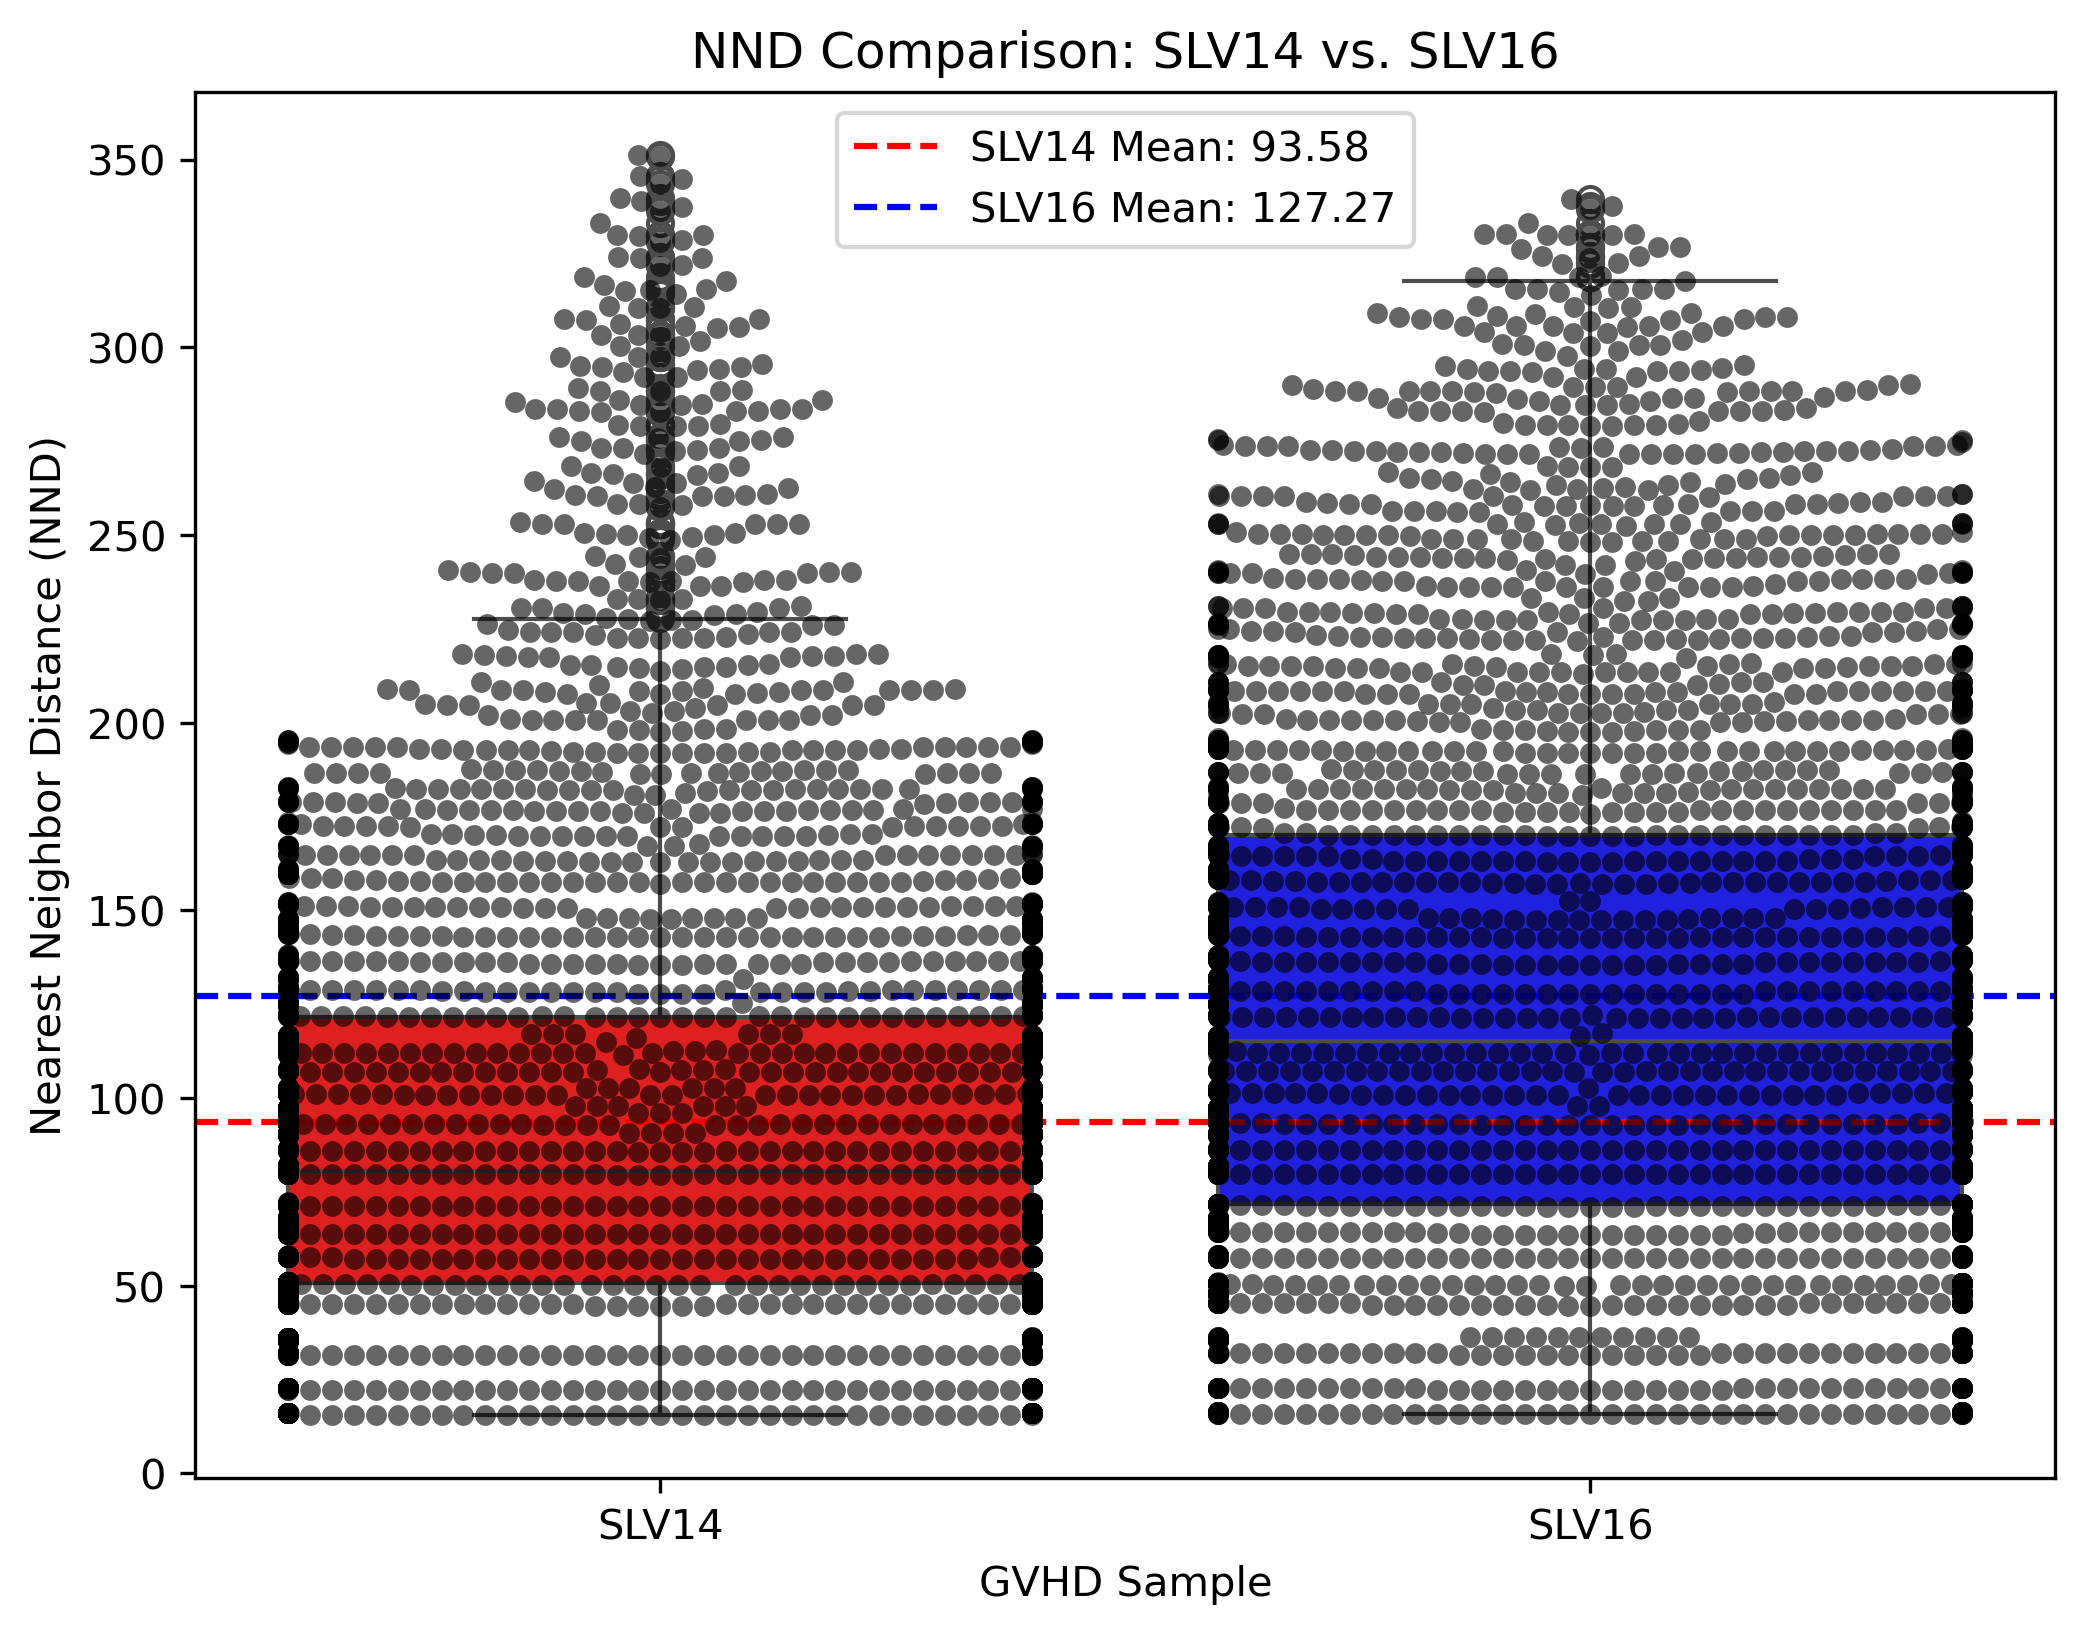


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 5843723.00000
Wilcoxon p-value: 0.00000
Cohen's d: -0.52179
Mean NND SLV14: 93.58202
Mean NND SLV16: 127.27299


In [53]:
# Compute NND for SLV14 and SLV16
nnd_slv14 = compute_nndistance(adata_integrate, cell_type2="CD8+ Effector T cells", cell_type1="stem", sample_id="SLV14")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type2="CD8+ Effector T cells", cell_type1="stem", sample_id="SLV16")

# Compare NND between SLV14 and SLV16
results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV14", label2="SLV16")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

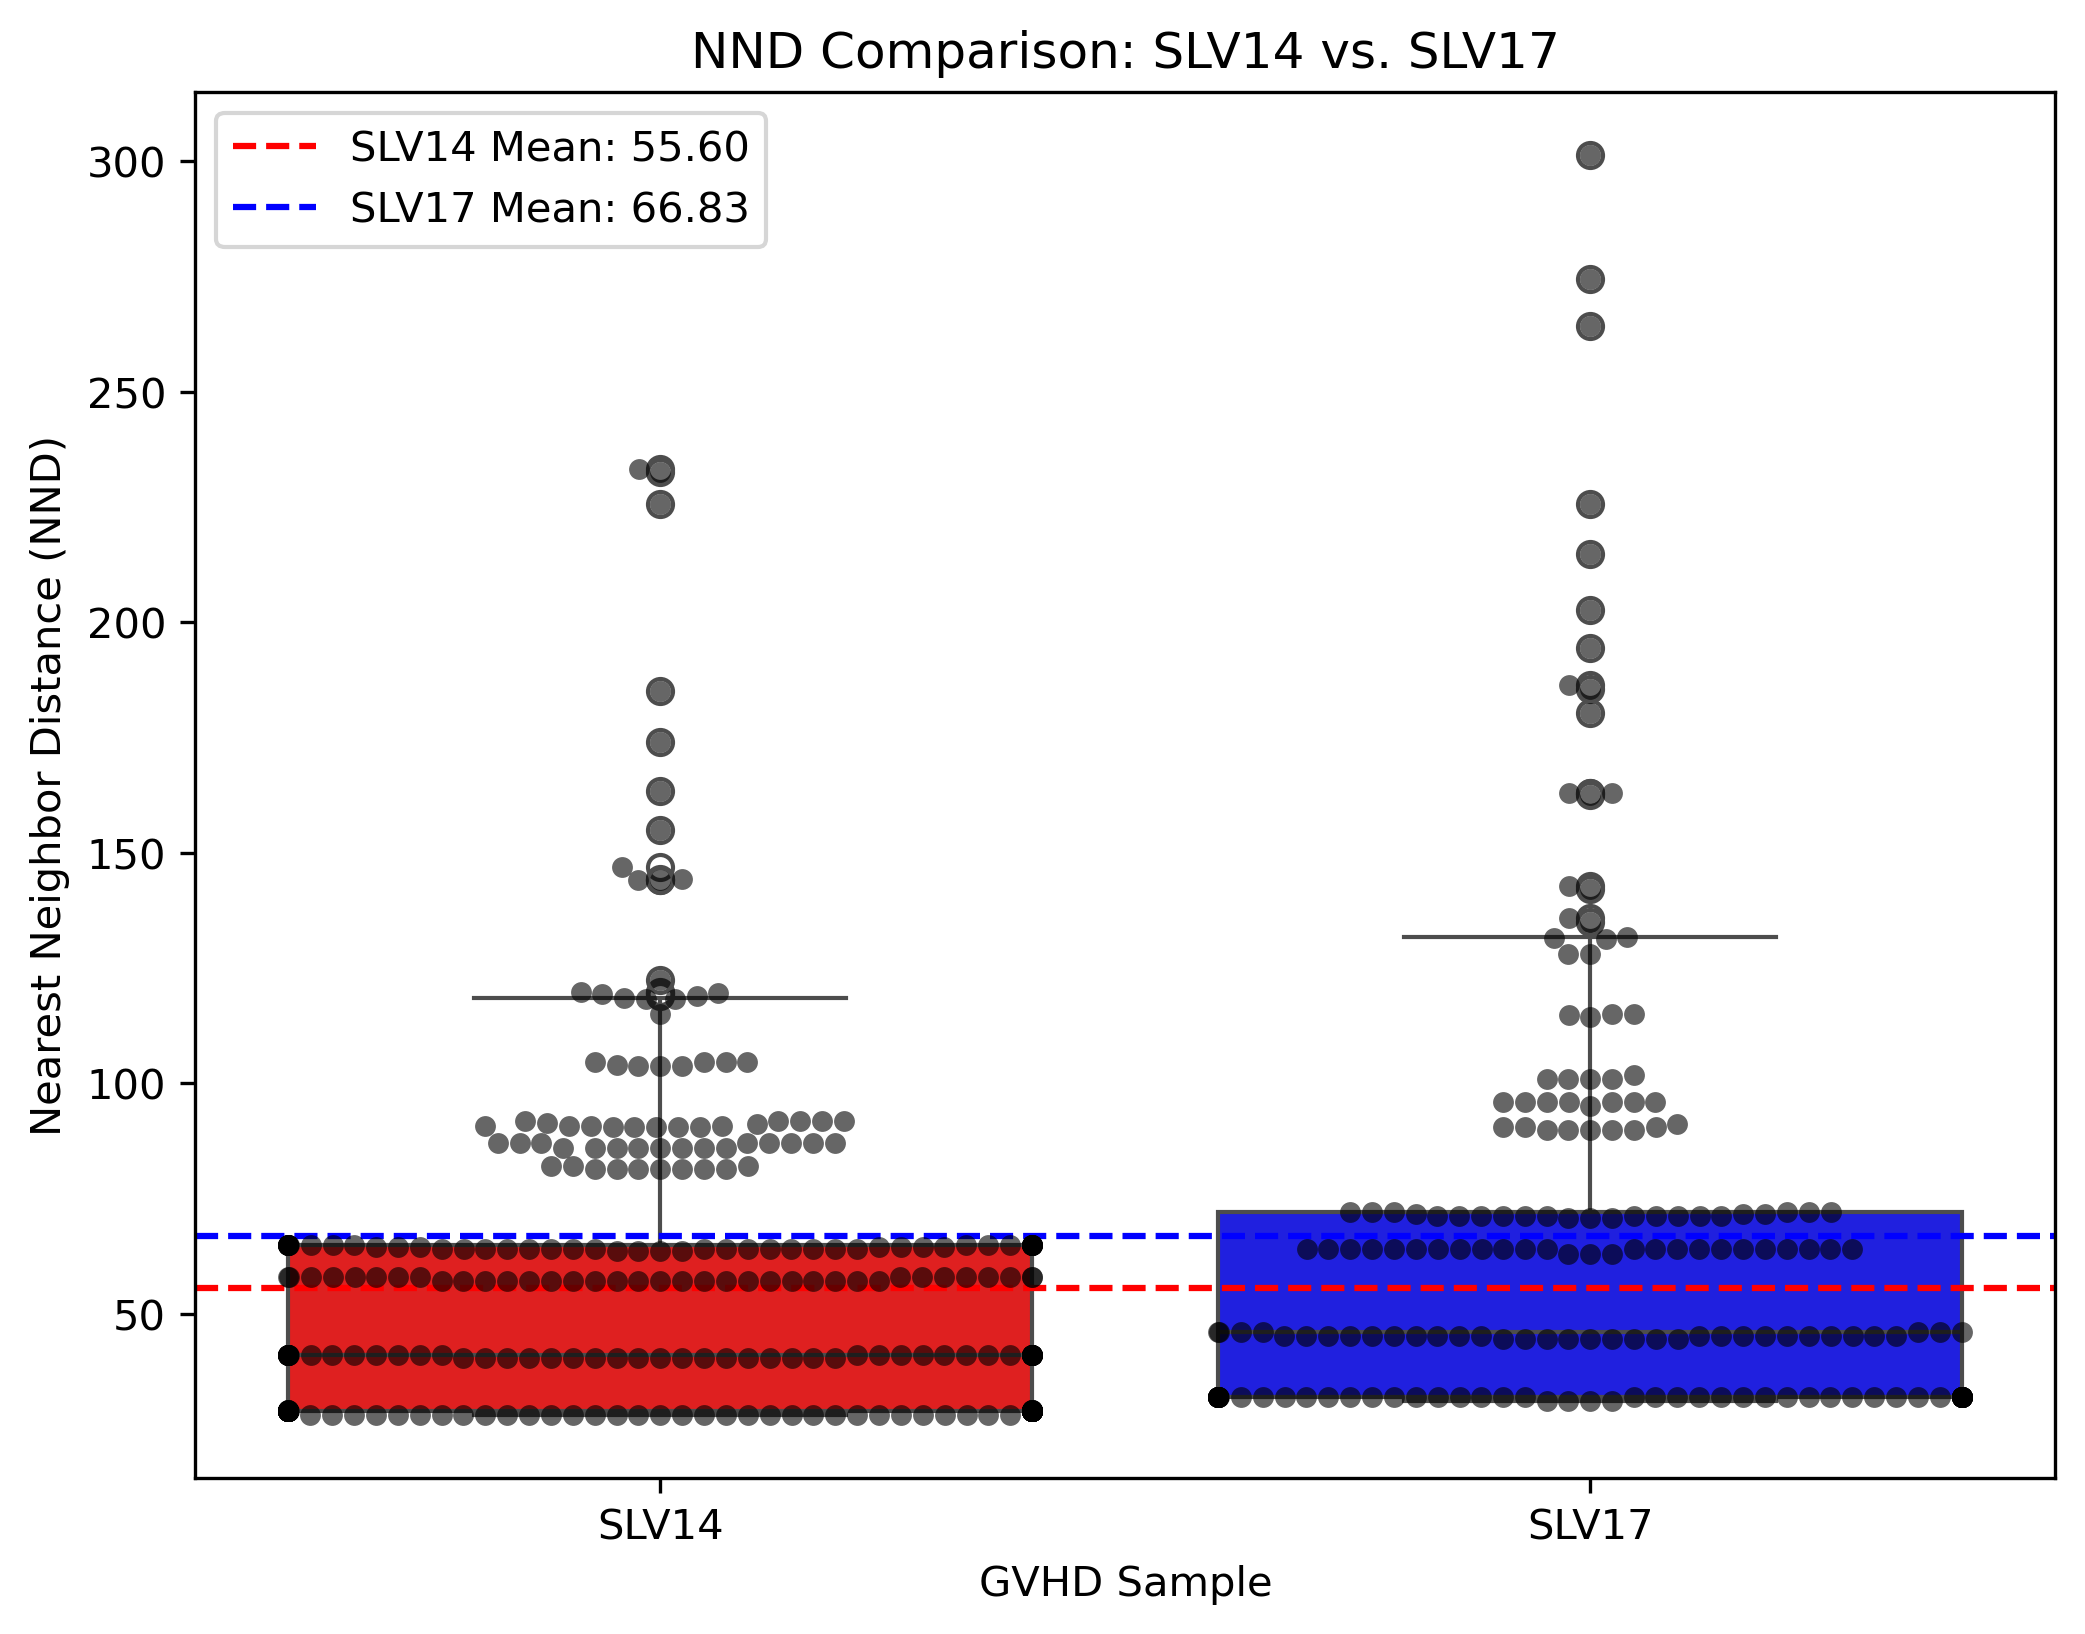


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 26282.00000
Wilcoxon p-value: 0.00000
Cohen's d: -0.27289
Mean NND SLV14: 55.60263
Mean NND SLV17: 66.82880


In [38]:
# Compute NND for SLV14 and SLV16
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV14")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV17")

# Compare NND between SLV14 and SLV16
results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV14", label2="SLV17")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

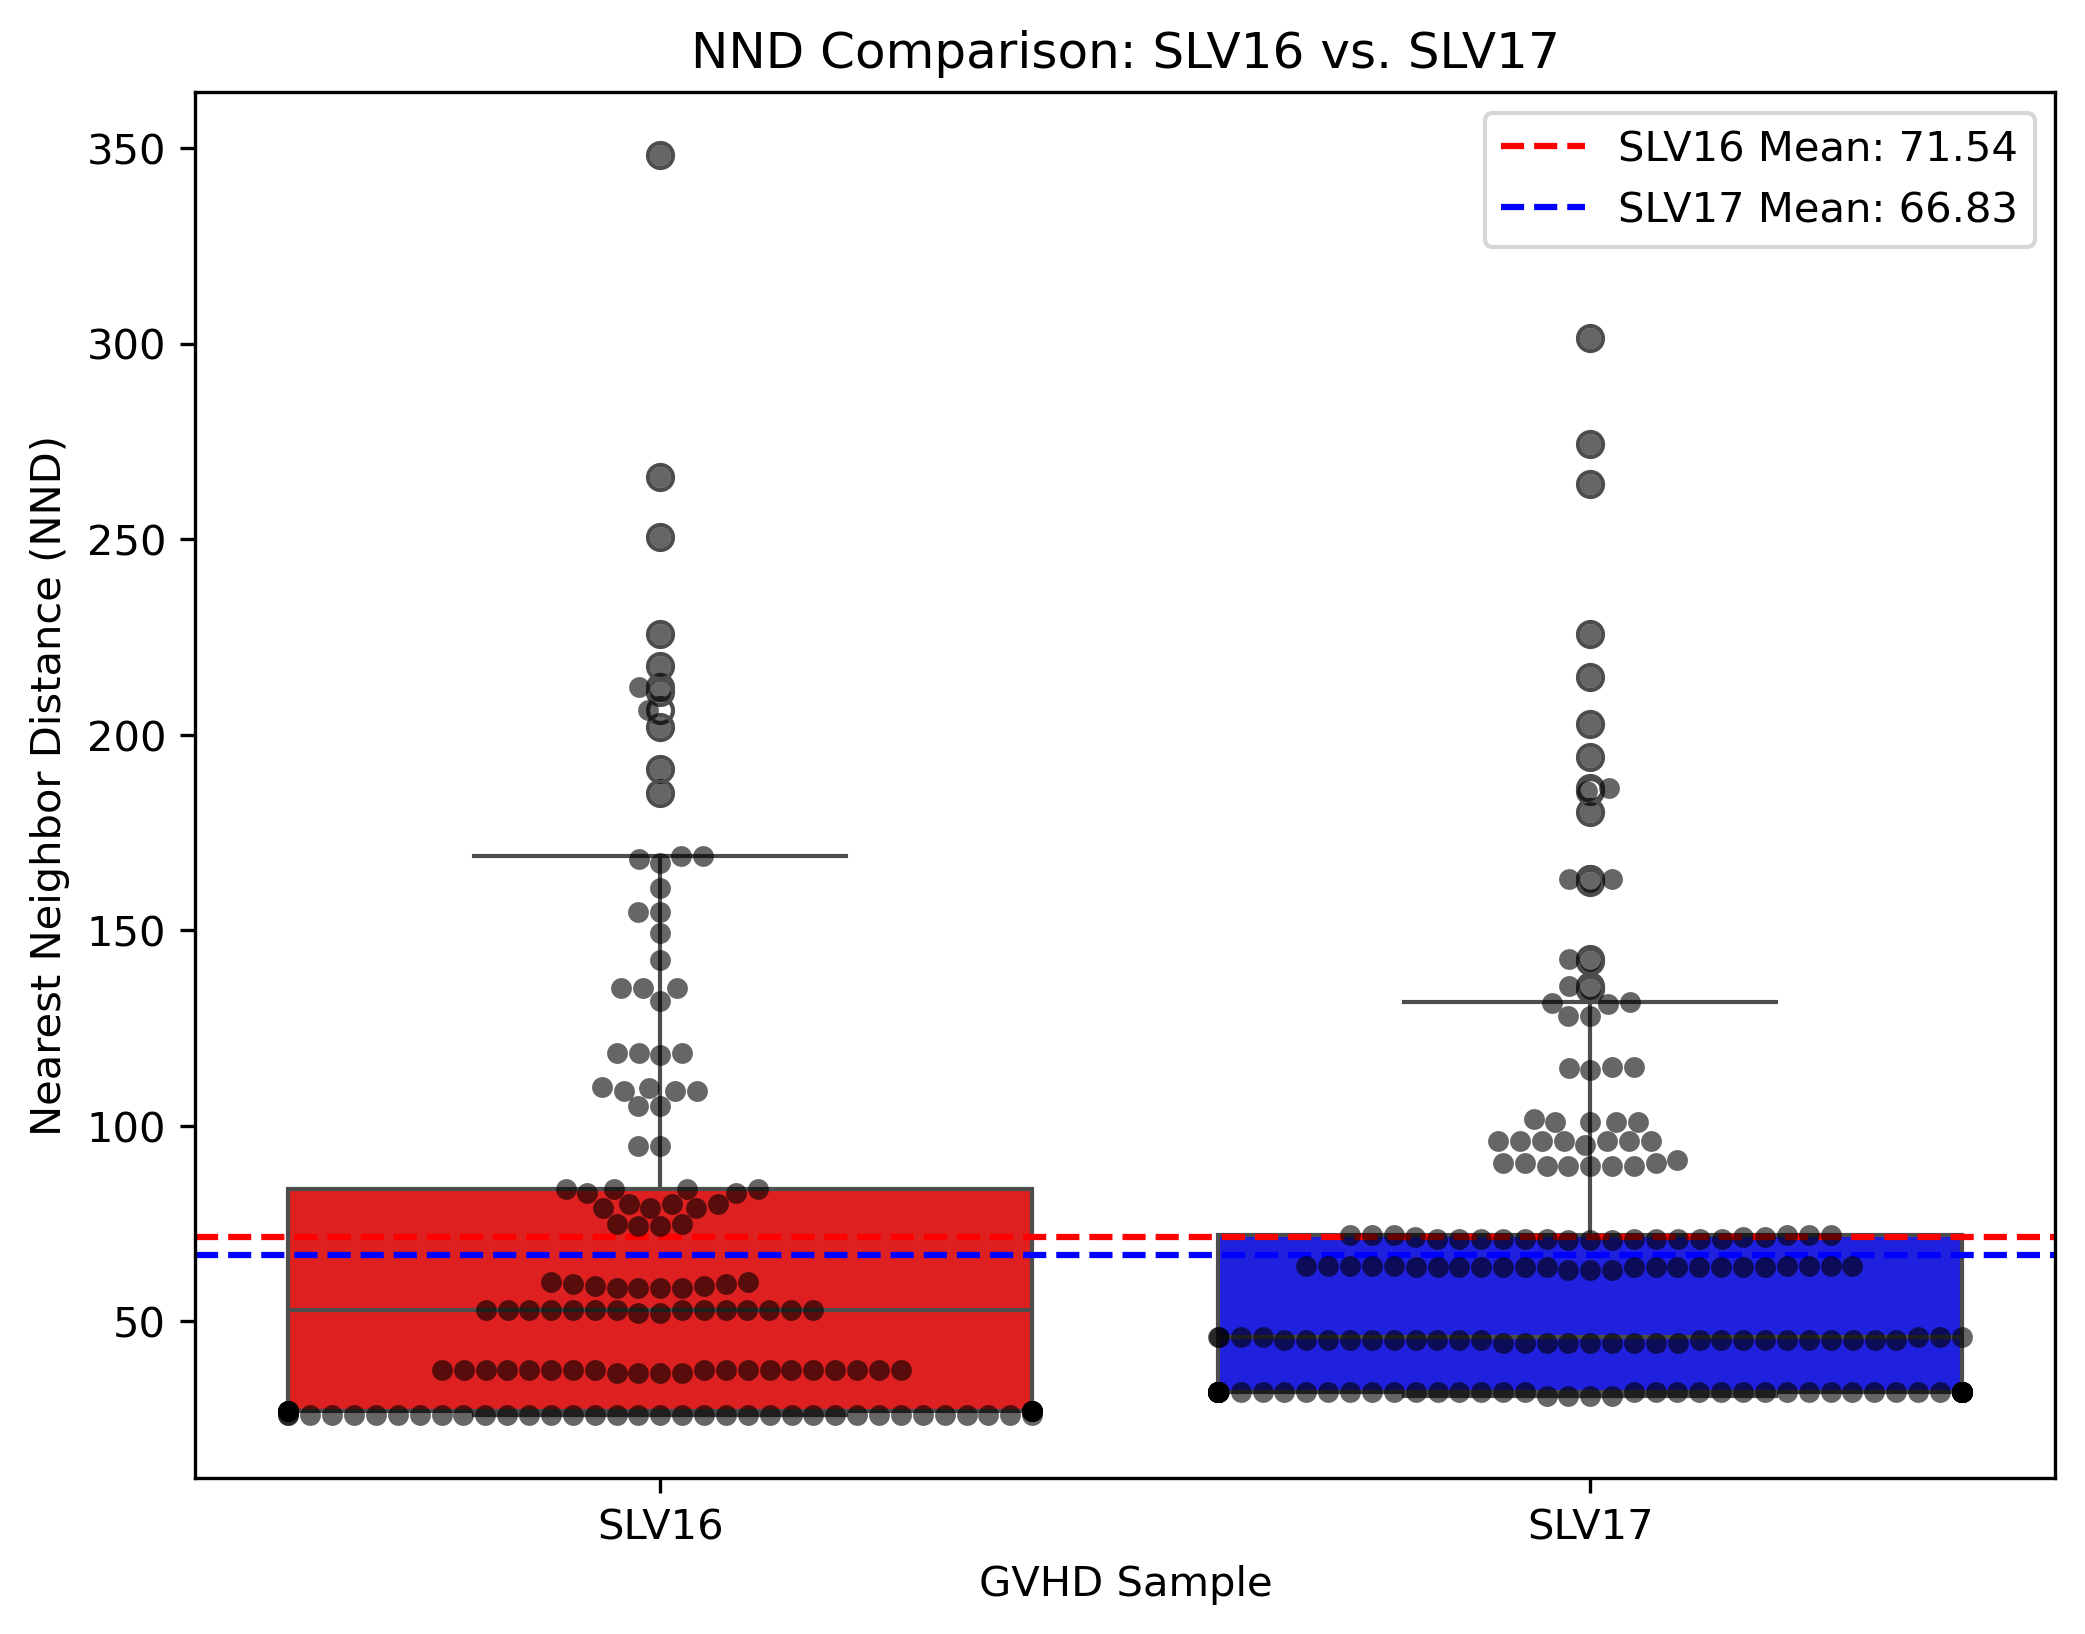


--- Statistical Comparison Results ---
Wilcoxon Test Statistic: 13921.00000
Wilcoxon p-value: 0.12741
Cohen's d: 0.08719
Mean NND SLV16: 71.53780
Mean NND SLV17: 66.82880


In [39]:
# Compute NND for SLV14 and SLV16
nnd_slv14 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV16")
nnd_slv16 = compute_nndistance(adata_integrate, cell_type1="CD8+ Effector T cells", cell_type2="stem", sample_id="SLV17")

# Compare NND between SLV14 and SLV16
results = compare_nnd_between_samples(nnd_slv14, nnd_slv16, label1="SLV16", label2="SLV17")

# Print statistical results
print("\n--- Statistical Comparison Results ---")
for key, value in results.items():
    print(f"{key}: {value:.5f}" if isinstance(value, float) else f"{key}: {value}")

In [40]:
adata.uns['spatial']

{'SLV11': {'images': {'hires': array([[[0.9423077 , 0.9182692 , 0.92788464],
           [0.9375    , 0.9230769 , 0.92788464],
           [0.9375    , 0.9230769 , 0.9326923 ],
           ...,
           [0.94711536, 0.92788464, 0.9326923 ],
           [0.94711536, 0.9230769 , 0.9326923 ],
           [0.94711536, 0.9230769 , 0.9326923 ]],
   
          [[0.9375    , 0.9182692 , 0.92788464],
           [0.9375    , 0.9230769 , 0.92788464],
           [0.9375    , 0.9230769 , 0.9326923 ],
           ...,
           [0.94711536, 0.9230769 , 0.9326923 ],
           [0.94711536, 0.9230769 , 0.92788464],
           [0.94711536, 0.9230769 , 0.92788464]],
   
          [[0.9375    , 0.9230769 , 0.9326923 ],
           [0.9375    , 0.9230769 , 0.9326923 ],
           [0.9375    , 0.9230769 , 0.9326923 ],
           ...,
           [0.94711536, 0.9230769 , 0.9326923 ],
           [0.94711536, 0.9230769 , 0.92788464],
           [0.94711536, 0.92788464, 0.92788464]],
   
          ...,
   
        

#### Compute_NND

In [ ]:
import matplotlib.cm as cm
import seaborn as sns

my_cmap = cm.get_cmap('RdBu_r')
def compute_NND(
    adata,
    cell_type1,
    cell_type2,
    return_mean=True
):
    np.random.seed(0)
    
    # Subset the closest 100 spots to filter out 
    from scipy.spatial import cKDTree
    def __compute_nnd(coords1, coords2):
        """coords 1: ref, coords2: query"""
        tree = cKDTree(coords1)
        distances, _ = tree.query(coords2, k=1)
        return distances


    # Get enriched spots per cell type
    coords = adata.obsm['spatial']
    ct2_spots = coords[adata.obs['stem']== cell_type2]
    if cell_type1 is None:
        print('Constructing random null NND distribution by random sampling...')
        indices = np.random.choice(np.arange(adata.shape[0]), len(ct2_spots), replace=False)
        ct1_spots = coords[indices]
    else:
        #adata.obs[cell_type1+'_enriched'] = adata.obs[cell_type1] > enriched_threshold
        ct1_spots = coords[adata.obs['stem']== cell_type1]

    # Compute ref (ct1) -> query (ct2) distance
    nnds = __compute_nnd(ct1_spots, ct2_spots)

    try:
        adata.obs.drop(adata.uns['cell_types'], axis=1, inplace=True)
        adata.obs.drop(cell_type2+'_enriched', axis=1, inplace=True)
        adata.obs.drop(cell_type1+'_enriched', axis=1, inplace=True)
    except Exception:
        pass

    return np.mean(nnds) if return_mean else nnds

In [ ]:
sample = "SLV14"
adata = adata_integrate[adata_integrate.obs['sample']==sample]
nnds_CD8_to_epi = compute_NND(adata,'stem', 'CD8+ Effector T cells',return_mean=False )
nnds_CD4_to_epi = compute_NND(adata,'stem', 'CD4+ Effector T cells', return_mean=False )

fig, (ax1, ax2) = plot_dual_violin(
    np.log(nnds_CD8_to_epi), np.log(nnds_CD4_to_epi),
    y1_label='CD8+ Effector T cells',
    y2_label='CD4+ Effector T cells',
    sample_id=sample,
    title=f"{sample}",
    y_label = 'Distance',
    figsize=(2,2))

In [ ]:
for i in sorted(adata_integrate.obs['sample'].unique()):
    print(i)
    adata_integrate_temp = adata_integrate[adata_integrate.obs['sample']==i]
    adata_integrate_temp_tumor = adata_integrate_temp[adata_integrate_temp.obs['hub'].isin(hub_tumor_list)]
    adata_integrate_temp_tumor_treg = adata_integrate_temp[adata_integrate_temp.obs['CD8+ Effector T  cells']>0.02]
    
    plt.figure()
    
    g=plt.scatter(adata_integrate_temp.obsm['spatial'][:,0],-adata_integrate_temp.obsm['spatial'][:,1],
                c = 'lightgray',
                s=0.3,
                  edgecolor = 'none'
               )
    g2=plt.scatter(adata_integrate_temp_tumor.obsm['spatial'][:,0],-adata_integrate_temp_tumor.obsm['spatial'][:,1],
                c = np.array(adata_normed_all[adata_integrate_temp_tumor.obs_names,'GZMK'].to_df()),
                s=0.3,
                  edgecolor = 'none'
               )
    g2=plt.scatter(adata_integrate_temp_tumor_treg.obsm['spatial'][:,0],-adata_integrate_temp_tumor_treg.obsm['spatial'][:,1],
                c = 'b',
                s=0.3,
                  edgecolor = 'none'
               )
    plt.colorbar(g)
    plt.title(i)


In [ ]:
for i in sorted(adata_integrate.obs['sample'].unique()):
    print(i)
    adata_integrate_temp = adata_integrate[adata_integrate.obs['sample']==i]
    adata_integrate_temp_tumor = adata_integrate_temp[adata_integrate_temp.obs['hub'].isin(hub_tumor_list)]
    plt.figure()
    
    g=plt.scatter(adata_integrate_temp.obsm['spatial'][:,0],-adata_integrate_temp.obsm['spatial'][:,1],
                c = adata_integrate_temp.obs['Treg'],
                vmax=0.05,
                s=0.5
               )

    plt.colorbar(g)
    plt.title(i)


In [ ]:
from sklearn.neighbors import KDTree

In [ ]:
def recluster_sample(adata_normed_all, adata_integrate,img_metadata_all,sample_id):
    adata_i = adata_normed_all[(adata_integrate.obs['sample']==sample_id)#&
                               #(adata_integrate.obs['hub'].isin(tumor_hubs))
                              ]
    map_info_hub = img_metadata_all[sample_id]['map_info']
    adata_i.obsm['X_pca'] = adata_integrate[adata_i.obs_names].obs.iloc[:,14:14+29]
    #sce.tl.phenograph(adata_i, clustering_algo="louvain", k=250)
    #adata_i.obs['hub_new'] = adata_i.obs['pheno_louvain'].astype('category')
    adata_i.obs['hub'] = adata_integrate[(adata_integrate.obs['sample']==sample_id)#&
                               #(adata_integrate.obs['hub'].isin(tumor_hubs))
                              ].obs['hub'].astype('category')
    adata_i.obs[['array_col','array_row']] = map_info_hub.loc[:,['array_col','array_row']]
    for i in adata_integrate[adata_i.obs_names].obs.iloc[:,14:14+29].columns:
        adata_i.obs[i] = adata_integrate[adata_i.obs_names].obs.loc[:,i]
    return adata_i

In [ ]:
MBC_3A = recluster_sample(adata_normed_all, adata_integrate,img_metadata_all,'MBC_3A')
MBC_3B = recluster_sample(adata_normed_all, adata_integrate,img_metadata_all,'MBC_3B')
MBC_4A = recluster_sample(adata_normed_all, adata_integrate,img_metadata_all,'MBC_4A')
MBC_4B = recluster_sample(adata_normed_all, adata_integrate,img_metadata_all,'MBC_4B')


In [ ]:
def get_dist_gene_mean(dist_all):
    len_ =25
    data = pd.DataFrame(np.linspace(0,int(dist_all['dist'].max())+1,len_),columns=['distance'])
    data_mean_ = []
    data_std_ = []
    for i in range(0,len_):
        if i>0:
            temp_ = dist_all[(dist_all['dist']<=data['distance'][i])&
                        (dist_all['dist']>=data['distance'][i-1])
                                                       ]
            temp_ = temp_['gene']
            temp_ = temp_.values#X.toarray().flatten()
    
            if len(temp_)>0:
                data_mean_.append(temp_.mean())
                if np.isnan(temp_.std()):
                    data_std_.append(data_std_[-1])
                else:
                    data_std_.append(temp_.std())
            else:
                data_mean_.append(data_mean_[-1])
                data_std_.append(data_std_[-1])
        else:
            data_mean_.append(0)
            data_std_.append(0)
    
    data['mean'] = data_mean_
    data['std'] = data_std_
    return data

In [ ]:
adata_normed_all

In [ ]:
def spot_along_Treg_dist(adata_i,adata_integrate, 
                         adata_normed_all,tumor_hub,
                         gene,
                         window_size
                        ):
    
    adata_tumor = adata_i[adata_i.obs['hub'].isin(tumor_hub)]
    hub_treg = []
    adata_tumor_treg = adata_tumor[adata_tumor.obs['Treg']>0.04]
    map_info_hub = adata_i.obs[['array_col','array_row']]
    map_info_hub_X = map_info_hub[map_info_hub.index.isin(adata_tumor_treg.obs.index)]
    map_info_hub_X = np.array(pd.DataFrame(map_info_hub_X)[['array_col','array_row']])
    tree = KDTree(map_info_hub_X, leaf_size=2) 

    dist_all = pd.DataFrame(columns=['dist'],index =adata_i.obs.index)
    distance = []
    for i in adata_i.obs.iterrows():
        rows=[i[0]]
        cols=['array_col','array_row']
        X =np.array(map_info_hub.loc[rows, cols])
        dist, ind = tree.query(X, k=1)
        distance.append(dist[0][0])
    dist_all['dist'] = distance
    dist_all['gene'] = adata_normed_all.to_df().loc[dist_all.index,gene]
    dist_all = dist_all.loc[adata_tumor.obs.index,:]
    dist_all = dist_all.sort_values(by ='dist')

    dist_all_ave = pd.DataFrame(columns=['dist','gene','sampleid'])
    dist = []
    gene =[]
    for number in dist_all.groupby('dist'):
        dist.append(number[0])
        gene.append(np.mean(number[1]['gene']))
    
    dist_all_ave['dist']= dist
    dist_all_ave['gene']= gene
    dist_all_ave['sampleid'] = sample_id

    
    sw_dist_all_ave=pd.DataFrame(columns=['dist','gene'])
    sw_dist= []
    sw_gene = []
    for i in range(np.max(dist_all_ave.index.values-window_size)):
        window = list(range(i,i+window_size,1))
        sw_dist.append(np.mean(dist_all_ave['dist'][window]))
        sw_gene.append(np.mean(dist_all_ave['gene'][window]))
        
    sw_dist_all_ave['dist']= sw_dist
    sw_dist_all_ave['gene']= sw_gene
    sw_dist_all_ave['gene'] = sw_dist_all_ave['gene']/sw_dist_all_ave['gene'].mean()
    
    return dist_all_ave, sw_dist_all_ave


In [ ]:

s=2
alpha=0.8

gene = 'FGFR2'
dist_MBC_3A, dist_MBC_3A_smooth = spot_along_Treg_dist(MBC_3A,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=15)
dist_MBC_3B, dist_MBC_3B_smooth = spot_along_Treg_dist(MBC_3B,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=10)
dist_MBC_4A, dist_MBC_4A_smooth = spot_along_Treg_dist(MBC_4A,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
dist_MBC_4B, dist_MBC_4B_smooth = spot_along_Treg_dist(MBC_4B,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
fig, ax = plt.subplots(figsize=(3,2),dpi=900)
s=2
alpha=0.8

ax.scatter(dist_MBC_3A_smooth['dist'], dist_MBC_3A_smooth['gene'], 
               s=s, 
           color='red', 
           alpha=alpha)

ax.scatter(dist_MBC_3B_smooth['dist'], dist_MBC_3B_smooth['gene'], 
               s=s, 
           color='green', 
           alpha=alpha)

ax.scatter(dist_MBC_4A_smooth['dist'], dist_MBC_4A_smooth['gene'], 
               s=s, 
           color='purple', 
           alpha=alpha)

ax.scatter(dist_MBC_4B_smooth['dist'], dist_MBC_4B_smooth['gene'], 
               s=s, 
           color='#0c70ad', 
           alpha=alpha)


dist_all = pd.concat([dist_MBC_3A_smooth,
                      dist_MBC_3B_smooth,
                      dist_MBC_4A_smooth, 
                      dist_MBC_4B_smooth])


data = pd.DataFrame(np.linspace(int(dist_all['dist'].min()),
                                int(dist_all['dist'].max())+1,20),
                    columns=['distance'])
data_mean_ = []
data_std_ = []
for i in range(0,20-1):
    if i >0:
        temp_ = dist_all[(dist_all['dist']<=data['distance'][i+1])&
                    (dist_all['dist']>=data['distance'][i])
                                     ]
    else: 
        temp_ = dist_all[(dist_all['dist']<=data['distance'][i+1])
                                     ]
    temp_ = temp_['gene']
    temp_ = temp_.values#X.toarray().flatten()

    if len(temp_)>0:
        data_mean_.append(temp_.mean())
        if np.isnan(temp_.std()):
            data_std_.append(data_std_[-1])
        else:
            data_std_.append(temp_.std())
    else:
        data_mean_.append(data_mean_[i-1])
        data_std_.append(data_std_[i-1])

data_mean_.append(data_mean_[-1])
data_std_.append(data_std_[-1])
data['mean'] = data_mean_
data['std'] = data_std_
# Smoothing
Final_array_smooth = gaussian_filter1d(data['mean'], sigma=2)
# Error formating
upper_err = gaussian_filter1d(data['mean'] + (data['std']), sigma=2)
lower_err = gaussian_filter1d(data['mean'] - (data['std']), sigma=2)

#ax.scatter(data['time'], data['mean'],  s=1, color='k', alpha=0.45)
colors_ = 'k'
ax.plot(data['distance'], Final_array_smooth,c=colors_)

ax.fill_between(data['distance'], upper_err, lower_err, color=colors_, alpha=0.1)

#ax.set_ylim(np.min(data['mean'])-(np.min((data['mean'])*30)/50)-0.04, np.max(data['mean'])+(np.max((data['mean'])*30)/40))
#ax.set_xlabel('Distance')
#ax.set_ylabel(gene)
fig.savefig('/Users/siyuhe/Starfysh_revision/manuscript/fig4/4k1.pdf',dpi=1000, bbox_inches='tight', transparent=True)
fig.savefig('/Users/siyuhe/Starfysh_revision/manuscript/fig4/4k1.png',dpi=1000, bbox_inches='tight', transparent=True)


In [ ]:

s=2
alpha=0.8

gene = 'CD44'
dist_MBC_3A, dist_MBC_3A_smooth = spot_along_Treg_dist(MBC_3A,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
dist_MBC_3B, dist_MBC_3B_smooth = spot_along_Treg_dist(MBC_3B,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
dist_MBC_4A, dist_MBC_4A_smooth = spot_along_Treg_dist(MBC_4A,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
dist_MBC_4B, dist_MBC_4B_smooth = spot_along_Treg_dist(MBC_4B,adata_integrate, adata_normed_all,tumor_hub=hub_tumor_list,gene=gene,window_size=20)
fig, ax = plt.subplots(figsize=(3,2),dpi=900)
s=2
alpha=0.8

ax.scatter(dist_MBC_3A_smooth['dist'], dist_MBC_3A_smooth['gene'], 
               s=s, 
           color='red', 
           alpha=alpha)

ax.scatter(dist_MBC_3B_smooth['dist'], dist_MBC_3B_smooth['gene'], 
               s=s, 
           color='green', 
           alpha=alpha)

ax.scatter(dist_MBC_4A_smooth['dist'], dist_MBC_4A_smooth['gene'], 
               s=s, 
           color='purple', 
           alpha=alpha)

ax.scatter(dist_MBC_4B_smooth['dist'], dist_MBC_4B_smooth['gene'], 
               s=s, 
           color='#0c70ad', 
           alpha=alpha)


dist_all = pd.concat([dist_MBC_3A_smooth,
                      dist_MBC_3B_smooth,
                      dist_MBC_4A_smooth, 
                      dist_MBC_4B_smooth])


data = pd.DataFrame(np.linspace(int(dist_all['dist'].min()),
                                int(dist_all['dist'].max())+1,20),
                    columns=['distance'])
data_mean_ = []
data_std_ = []
for i in range(0,20-1):
    if i >0:
        temp_ = dist_all[(dist_all['dist']<=data['distance'][i+1])&
                    (dist_all['dist']>=data['distance'][i])
                                     ]
    else: 
        temp_ = dist_all[(dist_all['dist']<=data['distance'][i+1])
                                     ]
    temp_ = temp_['gene']
    temp_ = temp_.values#X.toarray().flatten()

    if len(temp_)>0:
        data_mean_.append(temp_.mean())
        if np.isnan(temp_.std()):
            data_std_.append(data_std_[-1])
        else:
            data_std_.append(temp_.std())
    else:
        data_mean_.append(data_mean_[i-1])
        data_std_.append(data_std_[i-1])

data_mean_.append(data_mean_[-1])
data_std_.append(data_std_[-1])
data['mean'] = data_mean_
data['std'] = data_std_
# Smoothing
Final_array_smooth = gaussian_filter1d(data['mean'], sigma=2)
# Error formating
upper_err = gaussian_filter1d(data['mean'] + (data['std']), sigma=2)
lower_err = gaussian_filter1d(data['mean'] - (data['std']), sigma=2)

#ax.scatter(data['time'], data['mean'],  s=1, color='k', alpha=0.45)
colors_ = 'k'
ax.plot(data['distance'], Final_array_smooth,c=colors_)

ax.fill_between(data['distance'], upper_err, lower_err, color=colors_, alpha=0.1)

#ax.set_ylim(np.min(data['mean'])-(np.min((data['mean'])*30)/50)-0.04, np.max(data['mean'])+(np.max((data['mean'])*30)/40))
#ax.set_xlabel('Distance')
#ax.set_ylabel(gene)
fig.savefig('/Users/siyuhe/Starfysh_revision/manuscript/fig4/4k2.pdf',dpi=1000, bbox_inches='tight', transparent=True)
fig.savefig('/Users/siyuhe/Starfysh_revision/manuscript/fig4/4k2.png',dpi=1000, bbox_inches='tight', transparent=True)
